
<center style ="font-size: x-large; font-weight: 600; line-height: 1.1;padding: 10px">
WEST Tokamak Electron Density Profile Modeled with a Cubic Spline and Infered from Interferometry with Bayesian Inference</center>  
<center>
Daniel Jordan
</center>
 
### Abstract:
<div style="text-align: justify; padding: 20px"> 
insert abstract here
</div>

#### Key words: Nuclear Fusion, Tokamak, Interferometry, Bayesian Inference, Cubic Splines

## Introduction
### Interferometry
Interferometry is a diagnostic technique commonly used in nuclear fusion devices to gain information about the plasma. Lasers traverse the plasma. The electron density alters refractive index of the plasma. This slows down the laser and causes a phase shift. It can be shown that the phase shift is proportional to the line integrated electron density over the line of sight.

$$\Delta\phi = 2.82\times10^{-15} \lambda \int n_e dl$$

Where $\Delta\phi$ is the phase shift of the laser, $\lambda$ is the wavelength of the laser and $n_e$ is the electron density. Using the measured phase shift and laser wavelength, interferometry devices report data of the line integrated density.

$$\int n_e dl = \frac{\Delta\phi}{2.82\times10^{-15} \lambda}$$

In the [WEST](https://west.cea.fr/en/Phocea/Vie_des_labos/Ast/ast_service.php?id_unit=330) device there are many lasers used. They are fired from the outer wall of the tokamak and reflected back from the inner wall for a double pass of the plasma, see Figure 1.

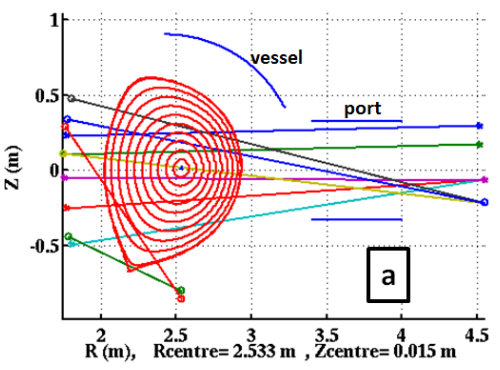
Figure 1: A diagram showing the cross section of the WEST tokamak. The red circles indicate magnetic flux surfaces. These are also surfaces of constant electron density. The colourd lines indicate the lines of sight of the interferometer lasers.

The electron density profile can be expressed in terms of the 2D axis $n_e(R,Z)$ or more elegantly in terms of $n_e(\rho)$. $R$ is the majour radial axis of the tokamak and Z the vertical axis. Where $n_e(\rho)$ is the electron density profile as a function of the normalised radious $\rho$. The electron density $(n_e)$ is known to be constant at magnetic flux surfaces, i.e. the red lines in figure 1. The normalised radious $\rho$ is 0 at the magnetic axis and 1 at the last closed magnetic flux surface. Every value of $\rho$ between corresponds to a different magnetic flux surface. Given infomation about the shape of the magnetic flux surfaces and $n_e(\rho)$ one can construct a complete plasma density profile, $n_e(R,Z)$. Thus the electron density profile is often expressed in one dimension along side the flux surfaces. Here is an example of a profile constructed with the NICE code at WEST and the corresponding flux surfaces.



In [1]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
from sampler_spline import sampler_spline_main
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


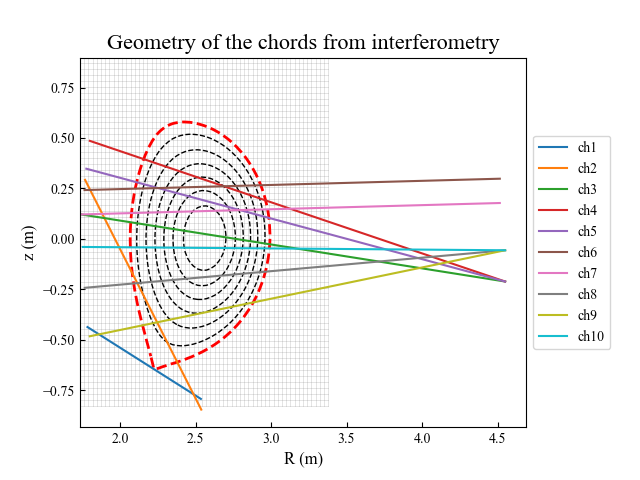

<IPython.core.display.Javascript object>


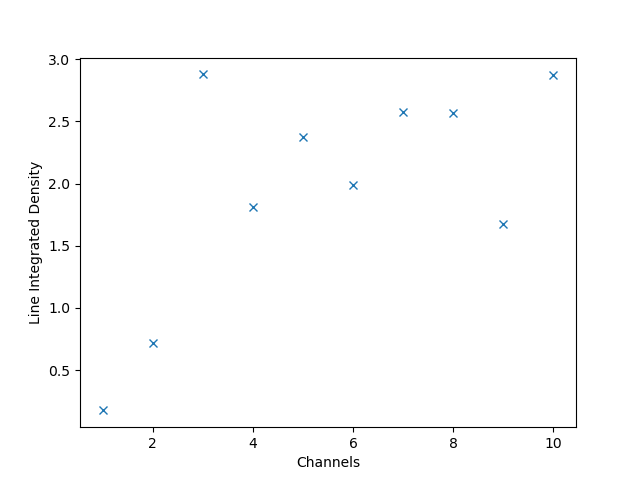

<IPython.core.display.Javascript object>


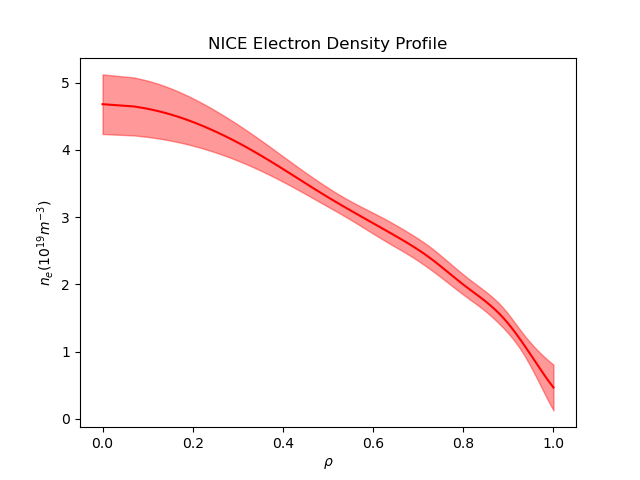

Text(0, 0.5, '$n_e (10^{19} m^{-3})$')

In [2]:
shot = 53259
t = 5.2113

geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}_occ1.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

figData = plt.figure()
plt.plot(interf.channels, interf.lid, 'x')
plt.xlabel('Channels')
plt.ylabel('Line Integrated Density')
plt.show()

#dens_prof.plot_density_profile()

figNICE = plt.figure()
plt.title('NICE Electron Density Profile')
nice_rho = dens_prof.rho_tor_norm_1d#np.linspace(0,1,101)
nice = dens_prof.dens_1d
nice_lower = dens_prof.dens_1d_lower
nice_upper = dens_prof.dens_1d_upper
plt.plot(nice_rho, nice, 'r')
plt.fill_between(nice_rho, nice_lower, nice_upper, color = (1,0,0,0.4), label='NICE 95% confidance interval')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$n_e (10^{19} m^{-3})$')

### Cubic Spline Function
This project uses a SciPy cubic spline to model the electron density profile, $n_e(\rho)$. The main paramaters for the function are a set of coordinates. SciPy then fits a cubic polynomial between each point ensuring the curvature matches up at each point to get an overall smooth function. It is also possible to specify the gradient at the edges of the spline. Below shows a SciPy cubic spline fit to a random set of points, where the gradient at the left is set to 0.

<IPython.core.display.Javascript object>


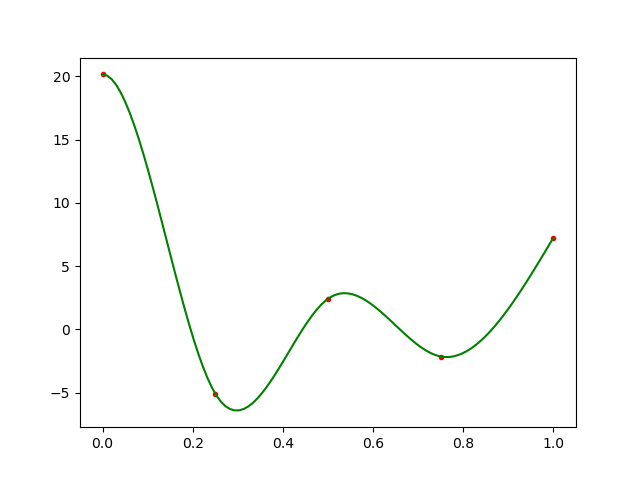

In [3]:
import numpy as np
randgen = np.random.default_rng(seed=49339389)
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

x = np.linspace(0,1,5)
y = randgen.normal(5,10,5)

spline = CubicSpline(x,y,bc_type=((1,0.0),(2,0.0)))

sx = np.linspace(0,1,100)
sy = spline(sx)
figSpline = plt.figure()
plt.plot(x,y, '.r',label='Origional Points')
plt.plot(sx,sy, '-g', label='Spline Fit')
plt.show()


The x-values of the points are commonly known as knots. In this project the y-values of the points shall be known as spline values. 

### Bayesian Inference
Bayes' theorem is a powerful tool that can assess the relative propability of something being true given there is a collection of data about it. In the terms of this interferometry project, it can be expressed as,

$$P[n_e(\rho)|\vec d, \sigma_{er}, \theta] = \frac{P[\vec d| n_e(\rho), \sigma_{er}] P[n_e(\rho, \theta)]}{P[\vec d, \sigma_{er},\theta]}$$.

The posterior, $P[n_e(\rho)|\vec d]$ represents the relative probability a specific density profile $n_e(\rho)$ is the true profile given a set of data $\vec d$. The data $\vec d$, is what is measured by interferometry and is subject to an experimental error, $\sigma_{er}$. The posterior in general is not intuitive to know, but the likelihood is. The likelihood $P[\vec d|n_e(\rho)]$, is the probability of getting a set of data $\vec d$ given a specific electron density profile. It can be expanded to show how it is a product of each individual measurement $d_i$,

$$P[\vec d|n_e(\rho), \sigma_{er}] = \prod_{i}^{m}P[d_i|n_e(\rho), \sigma_{er}].$$

The likelihood is influenced by the experimental error. In this project we assume a gaussian error and so the likelihood is simply,

$$P[d_i|n_e(\rho)] = \mathcal{N}(d_i, mean=LID_i, sdv=\sigma_{er})$$.

To avoid precision errors it is more convenient to work with the log likelihood. When taking the log of the analytical form of each gaussian and summing them we get,

$$
\log \left(P[\vec d|n_e(\rho), \sigma_{er}]\right) = m \times \log\left(\frac{1}{\sigma_{er}\sqrt{2\pi}}\right) + \sum_{i=1}^{m} -\frac{1}{2} \frac{(d_i - LID_i)^2}{\sigma_{er}^2} 
$$

The $LID_i$ is the Line Integrated Desnsity that would be measured by an error free version of the interferometry device given the density profile $n_e(\rho)$ is the ground truth. $LID_{n_e(\rho)}$ can be computed with the forward model which is a small simulation of an error free version of the WEST interferometry device. More on this later.

$P[\vec d]$ is the probability of data $\vec d$, and serves as a normalisation factor. It is ignored in this study as the shape of the posterior is the only factor that deterimes the most likely electron density profile.

$P[n_e(\rho)]$ is known as the prior distribution. It represents all knowledge of the plasma density profile before the experiment. This is in the form of assumed knowledge of the spline parameters. The exact distributions selected is different for my implimentations and will be explained later. 

The log posterior for a set of parameters and hyperparameters can be obtained by summing the log prior and log likelihood.

One method to perform the inference is to find the spline parameters that maxemise the posterior. This project uses a differential evolution algorythem from SciPy. Differential evolution is a population-based metaheuristic search algorithm that operates by improving a population of candidate solutions. The solutions are evaluated by the size of the posterior they lead to. It does not use the gradient, which means it is not sensitive to noisy functions. It is simple to implement and can efficiently explore large and complex search spaces. Although it can require a large number of function evaluations to reach the optimal solution and isn't suitable for for high-dimensional problems. It is inspired by evolution. It creates new solutions by adding the difference between two randomly chosen solutions to another randomly chosen solution. This is called the mutation operation. Then, it mixes some elements of the mutated solution with some elements of the original solution. This is called the crossover operation. The new solution is then compared with the original solution and the better one is kept. This is called the selection operation.  
  
Maxemising the posterior is great but it does not provide a degree of uncertinty. For this we turn to MCMC sampling. This project uses the python emcee package and its Ensemble Sampler. This algorithm runs multiple parallel chains (called walkers) and proposes new states for each walker by using the current states of the other walkers. States are accepted or rejected with the matropolis hasting criterion. If the walkers are initialised completly randomly then they can take some time before they begin to find the maximum of the posterior and sample from there more often than its edges. This means the initial samples often dont well reflect the posterior distribution. For this reason some initial number of samples are rejected. This is called the burn in. Although to decrese the amount of burn in required we can initialise the walkers to be a small random distance from the posterior maximum, which we know form deploying the differential evolution algorythem. After we have many samples of cubic spline parameters that reflect the posterior distribution we can convert them into profiles using the cubic spline function. The average of these profiles at each rho is an indication of the posterior maximum, and the 2.5% and 97.5% quantiles can be computed to give the 95% confidance interval and thus an idea on uncertainty.

In [4]:
from dask.distributed import Client
client = Client(n_workers=7)
import dask


In [5]:
client

<Client: 'tcp://127.0.0.1:33745' processes=7 threads=14, memory=15.62 GiB>

In [6]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
import numpy as np
from scipy.stats import multivariate_normal as mvn
import emcee
import time
from scipy import stats
from tqdm import tqdm
import optuna

/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# First Attempt 

The knot positions and spline values are free to move and have uniform priors. Except the core and edge knots positions are fixed, also the edge spline value $esv$ has a gaussian prior. The core gradient value $cgv$ also has a gaussian prior. The full prior is a product of the various distributions, 

$$
P[n_e(\rho)] = \mathcal{N}(esv, mean=0, \sigma_{esv}) \times Norm(cgv, mean=0, \sigma_{cgv}) \times (1^{-1})^{NKNOTS-2} \times (2 NICEmax)^{-1},
$$

where since 2 of the knots are already assigned to the core and edge there is NKNOTS-2 uniform priors for the knot positions. $2 NICEmax$ is around 10. Although the uniform priors take effect by simply restricting the values of the parameters within their bounds. They don't affect the shape of the posterior within these bounds and their constant values don't need to be multiplied in.  
  
Similiar to the likelihood using the logarithym helps avoid precision issues and then the prior is,  
  
$$
\log\left(P[n_e(\rho)]\right) = \log\left(\frac{1}{\sigma_{esv}\sqrt{2\pi}}\right) -\frac{1}{2}\frac{(esv)^2}{\sigma_{esv}^2} + \log\left(\frac{1}{\sigma_{cgv}\sqrt{2\pi}}\right) -\frac{1}{2}\frac{(cgv)^2}{\sigma_{esv}^2}
$$

also here the constants don't need to be included in the computation as they don't affect the shape of the posterior. 

The various parameters and their values/distributions are listed below.

Constants:
Interferometry Data, line integrated density of lasers, $\vec d$  
Edge Knot Location at $\rho=1$  
Core Knot Location at $\rho=0$  

Hyperparameters:     
Number of MCMC Burn Samples, NBURN = 500  
Number of MCMC Sample, NSAMPLES = 4000  
Number of MCMC Walkers = 2 $\times$ number of cubic spline parameters $= 2 \times 19 = 38$  
Number of Knots, NKNOTS = 10  
Experimental Error, $\sigma_{er}$ = 0.03 (as reported by WEST)   
Standard Deviation of Edge Spline Value, $\sigma_{esv}$ = 0.1   
Standard Deviation of Core Gradient Value, $\sigma_{cgv}$ = 0.1   
Bounds of Knot Locations uniform prior [0,1]  
Bounds of Spline Values uniform prior [0,10]

Cubic Spline Parameters:  
Knot Locations, uniform prior  
Spline Values (except edge), uniform prior  
Edge Spline Value, Gaussian prior  
Core Spline Gradient, Gaussian prior.  

Hyper Parameters Are:
{'NKNOTS': 10, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1}
Computing MAP
Results of MAP


 message: Optimization terminated successfully.
 success: True
     fun: 34.56033119996523
       x: [ 1.113e-02 -2.247e-02 ...  1.949e-01  5.820e-01]
     nit: 3022
    nfev: 861615


<IPython.core.display.Javascript object>


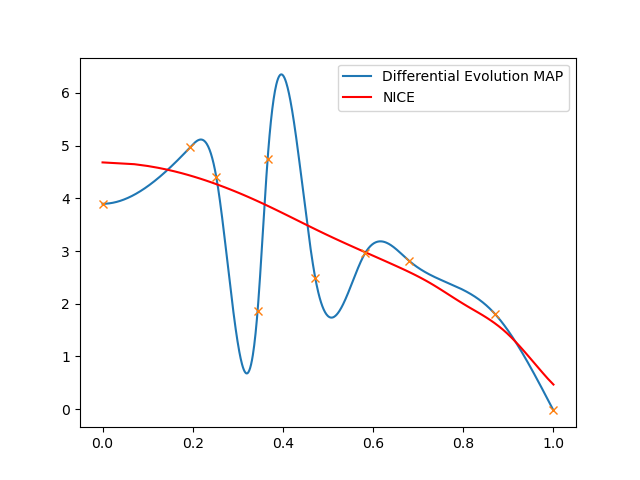

Performing MCMC Sampling of Posterior
MCMC sampling starts
Burn-in


100%|██████████| 500/500 [00:09<00:00, 53.14it/s]


Sampling


100%|██████████| 4000/4000 [01:05<00:00, 60.76it/s]
/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 22.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Sampling finished. Time Taken: 75.30061745643616 s
Converting the Samples to Profiles


100%|██████████| 21713/21713 [01:49<00:00, 198.79it/s]


Time Taken: 186.0089590549469 s
Computing the mean and 95% confidance intervals


<IPython.core.display.Javascript object>


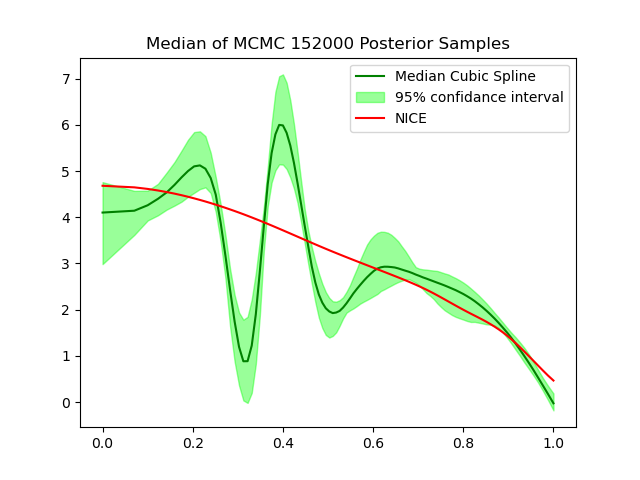

<IPython.core.display.Javascript object>


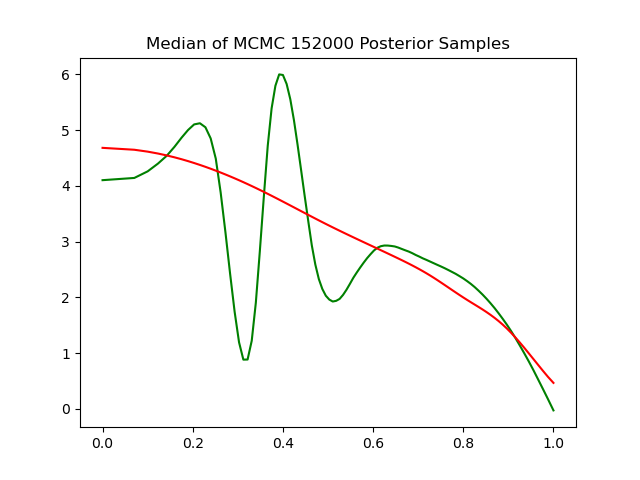

In [14]:
NBURN = 500
NSAMPLES = 4000

# Hyperparamters
NKNOTS = 5
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1

#might not be necessary any more since no uniform dist are used
BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,10) for i in range(NKNOTS-1)] + [(0,1) for i in range(NKNOTS-2)]
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 
rho_1000 = np.linspace(0,1,1000)
#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
d = interf.lid

hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv}
hyperbounds = {"NKNOTS":(3,40),"SIGer":(0,0.5),"SIGesv":(0,0.5),"SIGcgv":(0,0.5)}

class PosterioR:
    def __init__(self, hyperbounds, bounds, rho, R, d, nburn, nsamples):
        self.hyperbounds = hyperbounds
        self.bounds = bounds
        self.rho = rho
        self.R = R
        self.d = d
        self.nburn = nburn
        self.nsamples = nsamples
        self.params_map = None

    def Profile(self, params, rho, hyperparameters):
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
        knot_locations = params[NKNOTS+1:]
        all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        #ensure unique to avoid error, x must be increasing
        if len(np.unique(all_knots))<len(all_knots):
            all_knots = all_knots + np.linspace(0,0.000001,len(all_knots))
        sort = np.argsort(all_knots)
        cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
        n_e = cubic_spline(rho)
        return n_e
    def Plot_profile(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        fig_prof = plt.figure()
        plt.plot(self.rho, n_e)
    
    def Log_prior(self, params, hyperparameters):
            #check bounds
        within_bounds = True
        for i in range(len(params)):
            within_bounds = within_bounds and params[i] > self.bounds[i][0] and params[i] < self.bounds[i][1]
        if not within_bounds:
            return -np.inf    
        cgv, esv = params[0:2]
#         spline_values = params[2:NKNOTS+1]
#         knot_locations = params[NKNOTS+1:]
#         all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
#         all_spline_values = np.block([spline_values,esv])
        return -(esv**2 / hyperparameters['SIGesv']**2) - (cgv**2 /  hyperparameters['SIGcgv']**2)

    def Log_likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        LID = R @ n_e
        return np.sum(-(self.d - LID)**2 / hyperparameters['SIGer']**2)

    def Log_posterior(self, params, NKNOTS,SIGer,SIGesv,SIGcgv):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return -np.inf
        else:
            return log_prior + self.Log_likelihood(params, hyperparameters)
    
    def Neg_log_posterior(self, params, NKNOTS,SIGer,SIGesv,SIGcgv):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return +np.inf
        else:
            return -(log_prior + self.Log_likelihood(params, hyperparameters))
    
    def ComputeMAP(self, hyperparameters, verbose=False):
        print('Computing MAP')
        results = differential_evolution(self.Neg_log_posterior, self.bounds, workers=7, args=tuple(hyperparameters.values()), maxiter=5000)
        self.params_map = results.x
        if verbose:
            print('Results of MAP\n\n')
            print(results)            
            rho_1000 = np.linspace(0,1,1000)
            params_map=results.x
            cgv, esv = params_map[0:2]
            spline_values = params_map[2:NKNOTS+1]
            knot_locations = params_map[NKNOTS+1:]
            all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
            all_spline_values = np.block([spline_values,esv])
            figDifEv = plt.figure()
            plt.plot(rho_1000,self.Profile(results.x, rho_1000, hyperparameters),label='Differential Evolution MAP')
            plt.plot(RHO,nice, 'r', label='NICE')
            plt.plot(all_knots,all_spline_values,'x')
            plt.legend()
            plt.show()
        return self.params_map
    
    def MCMCsampling(self, hyperparameters, recompute_map=False):
        print('Performing MCMC Sampling of Posterior')
        ndim = len(self.bounds)
        nwalkers = ndim * 2
        if recompute_map:
            self.params_map = self.ComputeMAP(hyperparameters)
        params_start = self.params_map + randgen.uniform(0,0.01,(nwalkers, ndim))
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.Log_posterior, kwargs=(hyperparameters))
        print("MCMC sampling starts")
        time1 = time.time()
        print("Burn-in")
        state = sampler.run_mcmc(params_start, self.nburn, progress=True)
        sampler.reset()
        print('Sampling')
        sampler.run_mcmc(state, self.nsamples, progress=True, skip_initial_state_check=False)
        time2 = time.time()
        samples = sampler.get_chain(flat=True)
        print(f'Sampling finished. Time Taken: {time2 - time1} s')
        return samples
    
    def Likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        li = mvn(mean=self.R @ n_e, cov=np.diag(np.repeat(hyperparameters['SIGer'],len(d))))
        return li.pdf(self.d)
    
    def Log_marginal_likelihood(self, samples, hyperparameters):
        #maximizing the marginal likelihood is usefull for paramater optimisation
        #It will be estimates with Harmonic Mean Estimator, 
        #this is the inverse average of the likelihood with posterior samples 
        samples_7split = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Computing Likelihoods:')
        @dask.delayed
        def li_batch_compute(samples):      
            li = self.Likelihood(samples[0], hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                li = np.block([li, self.Likelihood(samples[i,:],hyperparameters)])
            return li
    
        li_batches = []
        for samples_batch in samples_7split:
            li_batches.append(li_batch_compute(samples_batch))

        li_batches = dask.compute(*li_batches)
        log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
        return log_marginal_likelihood
                                          
    def Neglogmargeli(self, hyperparameters):#NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
#             print('Trial Value',hyper_value)
#         hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        samples = self.MCMCsampling(hyperparameters, recompute_map=True)
        return -self.Log_marginal_likelihood(samples, hyperparameters)
      
    def Optimise_hyper(self, hyper, hyperparameters, study_name, verbose=False):
        print('\n\nOptimising the hyperparameter:',hyper)
        
        def objective(trial):
            hyper_value = trial.suggest_float(hyper, self.hyperbounds[hyper][0], self.hyperbounds[hyper][1])
            hyperparameters[hyper] = hyper_value
            return self.Neglogmargeli(hyperparameters)
        storage_name = "sqlite:///{}.db".format(study_name)
        study = optuna.create_study(study_name=study_name, storage=storage_name)
        study.optimize(objective, n_trials=100)
  # E.g. {'x': 2.002108042}

        if verbose:
            print('Results of Optimise for ',hyper,' are:', study.best_params[hyper])
        hyperparameters[hyper] = study.best_params[hyper]
        return hyperparameters
        
    def Plot_posterior(self, hyperparameters):
        time_s = time.time()
        @dask.delayed
        def samples2profiles(samples):
            profiles = self.Profile(samples[0,:], self.rho, hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                profiles = np.block([[profiles],
                                     [self.Profile(samples[i,:], self.rho, hyperparameters)]])
            return profiles
        
        samples = self.MCMCsampling(hyperparameters)
        samples_7 = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Converting the Samples to Profiles')
        profiles_batches = []
        for samples_batch in samples_7:
            profiles_batches.append(samples2profiles(samples_batch))
        profiles_batches = dask.compute(*profiles_batches)
        profiles = profiles_batches[0]
        for i in range(1,len(profiles_batches)):
            profiles = np.block([[profiles],
                                 [profiles_batches[i]]])
        print('Time Taken:', time.time() - time_s,'s')
        
        print('Computing the mean and 95% confidance intervals')
        
        profiles_mean = profiles.mean(axis=0)
        profiles_median = np.median(profiles, axis=0)
        profiles_mode = stats.mode(profiles, axis=0, keepdims=False).mode.flatten()
        profiles_lower = np.percentile(profiles, 2.5, axis=0)
        profiles_upper = np.percentile(profiles, 97.5, axis=0)
        figMCMC = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.fill_between(self.rho, profiles_lower, profiles_upper,color = (0,1,0,0.4),label='95% confidance interval')
        plt.plot(nice_rho, nice, 'r', label='NICE')
        plt.fill_between(nice_rho, nice_lower, nice_upper, color = (1,0,0,0.4), label='NICE 95% confidance interval')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        figMedain = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.plot(nice_rho,nice, 'r', label='NICE')  
        plt.plot(self.rho, self.Profile(self.params_map, self.rho, hyperparameters),label='MAP')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        return {'mean':profiles_mean,'median':profiles_median,'mode':profiles_mode,'lower':profiles_lower,'upper':profiles_upper}
         
        
post = PosterioR(hyperbounds, BOUNDS, RHO, R, d, NBURN, NSAMPLES)
print('Hyper Parameters Are:')
print(hyperparameters)
post.ComputeMAP(hyperparameters, verbose=True)
profile_averages = post.Plot_posterior(hyperparameters)
a=1                           

# Incorperating Smoothness

Looking at the differential evolution MAP we see how eradicly the inference places the spline values. We don't expect the electron density to be able to change so dramatically within the plasma and so there is some prior knowledge of smoothness that can be incorperated.

To incorperate smoothness I will use a multivariate gaussian with a stationary kernel as the prior for the spline values. Scipy.stats has a method for generating defining this multivariate Gaussian and computing its log_pdf value for an input set of cubic spline values $\vec{sv}$. This can be added to the previous log prior to combine them. It can be expressed as,

\begin{equation}
\begin{aligned}
&\mathcal{N}(\vec{sv}, \vec \mu_{pr} = \vec{0}, K) = \frac{1}{\sqrt{(2\pi)^{\frac{n}{2}}|K|}} \exp \left[{{-\frac{1}{2}\vec{sv}^\top K^{-1}\vec{sv}}}\right],\\
&K_{ij} = k(\rho_i, \rho_j) = \sigma^2 \exp\left[{\frac{(\rho_i - \rho_j)^2}{2l^2}}\right],
\end{aligned}
\end{equation}

where $\vec{sv}$ contains the spline vaues at each knot, the mean of each gaussian is set to $0$ with $\vec 0$ and the covariance matrix $K$ is set by the kernel $k$. The covariance matrix controls the dependance of each gaussians mean on the others. This kernel is known as the square exponential kernel, $\rho_i$ corrosponds to a knot position. The amplitude $\sigma$ fills the diagonal of the covariance matrix as on the diagonal $\rho_i = \rho_j$ and the exponential becomes $1$. The amplitude thus controlls the prior strength, a low alplidude leads to a multivariate Gaussian composed of multiple thin and pointy Gaussians of mean about the prior and thus the prior is very strong. Since we want our prior to be 'non informative' we should select a high value for the amplitude. The length scale $l$ controls the degree of smoothness of our inference as it controls how correlated each gaussian in the multivariate is. A high length scale means they are very correlated and from one knot to the next the spline value can't change a lot. The opposite is true of a low length scale. Deciding the best length scale value is difficult. A common way to optimise such hyperparameters is by maxemising the marginal likelihood. This method uses the data to find the hyper parameters that best alligns with the data but it also deploys occams razor which prevents overfitting.
  
To compute the marginal likelihood I deploy the harmonic mean estimator,

$$
    P[\vec d, \sigma_{er},\theta] = \frac{1}{N} \Sigma_{i=1}^{N} \frac{1}{\mathcal{L}(\vec n_e^i)},
$$

where $\vec n_e^i$ is sampled $N$ times from the posterior via MCMC sampling. $\mathcal{L}$ is the likelihood. This essentialy is the mean of the inverse likelihood when profile samples are taken from the posterior. The harmonic mean estimator is a simple method for estimating the marginal likelihood from posterior samples, but it can be very inaccurate and unstable due to the influence of small likelihood values. Several variants have been proposed to reduce its variance, but none are fully satisfactory. It is a challenging and open problem to improve this estimator. I decided to test its ability to tune the smoothness with the length scale.

The various parameters and their values/distributions are listed below.

Constants:
Interferometry Data, line integrated density of lasers, $\vec d$  
Edge Knot Location at $\rho=1$  
Core Knot Location at $\rho=0$  

Hyperparameters:
Amplitude, $\sigma$, amp = 50
Lengthscale, $l$ = 4, to be tuned
Number of MCMC Burn Samples, NBURN = 500, lowered to 50, for tuning l
Number of MCMC Sample, NSAMPLES = 4000, lowered to 400, for tuning l
Number of MCMC Walkers = 2*number of cubic spline parameters = 2*19 = 38
Number of Knots, NKNOTS = 10  
Experimental Error, $\sigma_{er}$ = 0.03 (as reported by WEST)   
Standard Deviation of Edge Spline Value, $\sigma_{esv}$ = 0.1   
Standard Deviation of Core Gradient Value, $\sigma_{cgv}$ = 0.1   
Bounds of Knot Locations uniform prior [0,1]  
Bounds of Spline Values uniform prior [0,10]

Cubic Spline Parameters:  
Knot Locations, uniform prior  
Spline Values (except edge), uniform prior  
Edge Spline Value, Gaussian prior  
Core Spline Gradient, Gaussian prior.  

In [16]:
NBURN = 500
NSAMPLES = 4000

# Hyperparamters
NKNOTS = 5
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1
AMP = 50
L = 4
#might not be necessary any more since no uniform dist are used
BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,10) for i in range(NKNOTS-1)] + [(0,1) for i in range(NKNOTS-2)]
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 
rho_1000 = np.linspace(0,1,1000)
#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
d = interf.lid

hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
hyperbounds = {"NKNOTS":(3,40),"SIGer":(0,0.5),"SIGesv":(0,0.5),"SIGcgv":(0,0.5),'AMP':(0,50),'L':(0,10)}

class PosteriorSmooth:
    def __init__(self, hyperbounds, bounds, rho, R, d, nburn, nsamples):
        self.hyperbounds = hyperbounds
        self.bounds = bounds
        self.rho = rho
        self.R = R
        self.d = d
        self.nburn = nburn
        self.nsamples = nsamples
        self.params_map = None

    def Kernel(self, rho1, rho2, hyperparameters):
        amp = hyperparameters['AMP']
        l = hyperparameters['L']
        RHOA, RHOB = np.meshgrid(rho1,rho2)
        return amp**2 * np.exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    
    def Profile(self, params, rho, hyperparameters):
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
        knot_locations = params[NKNOTS+1:]
        all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        #ensure unique to avoid error, x must be increasing
        if len(np.unique(all_knots))<len(all_knots):
            all_knots = all_knots + np.linspace(0,0.000001,len(all_knots))
        sort = np.argsort(all_knots)
        cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
        n_e = cubic_spline(rho)
        return n_e
    def Plot_profile(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        fig_prof = plt.figure()
        plt.plot(self.rho, n_e)
    
    def Log_prior(self, params, hyperparameters):
            #check bounds
        within_bounds = True
        for i in range(len(params)):
            within_bounds = within_bounds and params[i] > self.bounds[i][0] and params[i] < self.bounds[i][1]
        if not within_bounds:
            return -np.inf    
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
        knot_locations = params[NKNOTS+1:]
        all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        K = self.Kernel(all_knots,all_knots, hyperparameters) + np.diag(np.repeat(1e-5,NKNOTS))
        prior_spline_values = mvn(mean=np.zeros(NKNOTS), cov=K)
        return -(esv**2 / hyperparameters['SIGesv']**2) - (cgv**2 /  hyperparameters['SIGcgv']**2) + prior_spline_values.logpdf(x=all_spline_values)

    def Log_likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        LID = R @ n_e
        return np.sum(-(self.d - LID)**2 / hyperparameters['SIGer']**2)
    
    def Log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return -np.inf
        else:
            return log_prior + self.Log_likelihood(params, hyperparameters)
    
    def Neg_log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return np.inf
        else:
            return -(log_prior + self.Log_likelihood(params, hyperparameters))
    
    def ComputeMAP(self, hyperparameters, verbose=False):
        print('Computing MAP')
        results = differential_evolution(self.Neg_log_posterior, self.bounds, workers=7, args=tuple(hyperparameters.values()), maxiter=1000)
        self.params_map = results.x
        if verbose:
            print('Results of MAP for amp:',hyperparameters['AMP'],'and l:',hyperparameters['L'],'\n\n')
            print(results)
            print('Core Gradient Value:',results.x[0])
            print('Edeg Spline Value:',results.x[1])
            print('Other Spline Values:',results.x[2:])
            
            rho_1000 = np.linspace(0,1,1000)
            params_map=results.x
            cgv, esv = params_map[0:2]
            spline_values = params_map[2:NKNOTS+1]
            knot_locations = params_map[NKNOTS+1:]
            all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
            all_spline_values = np.block([spline_values,esv])
        
            figDifEv = plt.figure()
            plt.plot(rho_1000,self.Profile(results.x, rho_1000, hyperparameters),label='Differential Evolution MAP')
            plt.plot(nice_rho, nice, 'r', label='NICE')
            plt.plot(all_knots,all_spline_values,'x')
            plt.legend()
            plt.show()
        return self.params_map
    
    def MCMCsampling(self, hyperparameters, recompute_map=False):
        print('Performing MCMC Sampling of Posterior')
        ndim = len(self.bounds)
        nwalkers = ndim * 2
        if recompute_map:
            self.params_map = self.ComputeMAP(hyperparameters)
        params_start = self.params_map + randgen.uniform(0,0.01,(nwalkers, ndim))
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.Log_posterior, kwargs=(hyperparameters))
        print("MCMC sampling starts")
        time1 = time.time()
        print("Burn-in")
        state = sampler.run_mcmc(params_start, self.nburn, progress=True)
        sampler.reset()
        print('Sampling')
        sampler.run_mcmc(state, self.nsamples, progress=True, skip_initial_state_check=False)
        time2 = time.time()
        samples = sampler.get_chain(flat=True)
        print(f'Sampling finished. Time Taken: {time2 - time1} s')
        return samples
    
    def Likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        li = mvn(mean=self.R @ n_e, cov=np.diag(np.repeat(hyperparameters['SIGer'],len(d))))
        return li.pdf(self.d)
    
    def Log_marginal_likelihood(self, samples, hyperparameters):
        #maximizing the marginal likelihood is usefull for paramater optimisation
        #It will be estimates with Harmonic Mean Estimator, 
        #this is the inverse average of the likelihood with posterior samples 
        samples_7split = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Computing Likelihoods:')
        @dask.delayed
        def li_batch_compute(samples):      
            li = self.Likelihood(samples[0], hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                li = np.block([li, self.Likelihood(samples[i,:],hyperparameters)])
            return li
    
        li_batches = []
        for samples_batch in samples_7split:
            li_batches.append(li_batch_compute(samples_batch))

        li_batches = dask.compute(*li_batches)
        log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
        return log_marginal_likelihood
                                          
    def Neglogmargeli(self, hyperparameters):#NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
#             print('Trial Value',hyper_value)
#         hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        samples = self.MCMCsampling(hyperparameters, recompute_map=True)
        return -self.Log_marginal_likelihood(samples, hyperparameters)
      
    def Optimise_hyper(self, hyper, hyperparameters, study_name, verbose=False):
        print('\n\nOptimising the hyperparameter:',hyper)
        
        def objective(trial):
            hyper_value = trial.suggest_float(hyper, self.hyperbounds[hyper][0], self.hyperbounds[hyper][1])
            hyperparameters[hyper] = hyper_value
            return self.Neglogmargeli(hyperparameters)
        storage_name = "sqlite:///{}.db".format(study_name)
        study = optuna.create_study(study_name=study_name, storage=storage_name)
        study.optimize(objective, n_trials=100)
        if verbose:
            print('Results of Optimise for ',hyper,' are:', study.best_params[hyper])
        hyperparameters[hyper] = study.best_params[hyper]
        return hyperparameters
        
    def Plot_posterior(self, hyperparameters):
        time_s = time.time()
        @dask.delayed
        def samples2profiles(samples):
            profiles = self.Profile(samples[0,:], self.rho, hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                profiles = np.block([[profiles],
                                     [self.Profile(samples[i,:], self.rho, hyperparameters)]])
            return profiles
        
        samples = self.MCMCsampling(hyperparameters)
        samples_7 = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Converting the Samples to Profiles')
        profiles_batches = []
        for samples_batch in samples_7:
            profiles_batches.append(samples2profiles(samples_batch))
        profiles_batches = dask.compute(*profiles_batches)
        profiles = profiles_batches[0]
        for i in range(1,len(profiles_batches)):
            profiles = np.block([[profiles],
                                 [profiles_batches[i]]])
        print('Time Taken:', time.time() - time_s,'s')
        
        print('Computing the mean and 95% confidance intervals')
        
        profiles_mean = profiles.mean(axis=0)
        profiles_median = np.median(profiles, axis=0)
        profiles_mode = stats.mode(profiles, axis=0, keepdims=False).mode.flatten()
        profiles_lower = np.percentile(profiles, 2.5, axis=0)
        profiles_upper = np.percentile(profiles, 97.5, axis=0)
        figMCMC = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.fill_between(self.rho, profiles_lower, profiles_upper,color = (0,1,0,0.4),label='95% confidance interval')
        plt.plot(nice_rho, nice, 'r', label='NICE')
        plt.fill_between(nice_rho, nice_lower, nice_upper, color = (1,0,0,0.4), label='NICE 95% confidance interval')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        figMedain = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.plot(nice_rho,nice, 'r', label='NICE')  
        plt.plot(self.rho, self.Profile(self.params_map, self.rho, hyperparameters),label='MAP')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        return {'mean':profiles_mean,'median':profiles_median,'mode':profiles_mode,'lower':profiles_lower,'upper':profiles_upper}
  
                          
post_smooth = PosteriorSmooth(hyperbounds, BOUNDS, RHO, R, d, NBURN, NSAMPLES)

Hyper Parameters Are:
{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 4}
Computing MAP
Results of MAP for amp: 50 and l: 4 


 message: Optimization terminated successfully.
 success: True
     fun: 125.6948665803105
       x: [ 4.346e-02 -2.192e-03  4.628e+00  3.058e+00  2.756e+00
            2.529e-04  4.672e-01  5.320e-01  9.999e-01]
     nit: 547
    nfev: 74010
Core Gradient Value: 0.04346057151706362
Edeg Spline Value: -0.002192065811768895
Other Spline Values: [4.62812325e+00 3.05848107e+00 2.75558577e+00 2.52880460e-04
 4.67189386e-01 5.32014919e-01 9.99883671e-01]


<IPython.core.display.Javascript object>


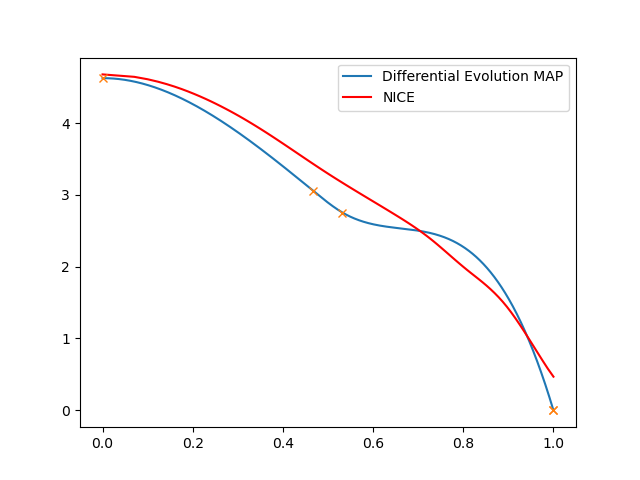

In [17]:
print('Hyper Parameters Are:')
print(hyperparameters)
post_smooth.ComputeMAP(hyperparameters, verbose=True)
a=1

In [19]:
post_smooth.nburn = 50
post_smooth.nsamples = 400
print(hyperparameters)
hyperparameters = post_smooth.Optimise_hyper('L', hyperparameters, study_name='optimise_l_smooth_5KNOTS2')
a=1

[I 2023-10-26 20:19:18,742] A new study created in RDB with name: optimise_l_smooth_5KNOTS2


{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 4}


Optimising the hyperparameter: L
Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.70it/s]


Sampling


 20%|██        | 206/1027 [00:00<00:00, 2054.45it/s]

Sampling finished. Time Taken: 7.118056058883667 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1868.61it/s]

100%|██████████| 1027/1027 [00:00<00:00, 1869.07it/s]
[I 2023-10-26 20:19:32,315] Trial 0 finished with value: 8.882201847427382 and parameters: {'L': 1.9220411600869458}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 196.59it/s]


Sampling


 19%|█▉        | 199/1027 [00:00<00:00, 1988.05it/s]

Sampling finished. Time Taken: 3.229430913925171 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1908.44it/s]
[I 2023-10-26 20:19:55,080] Trial 1 finished with value: 8.887486381706601 and parameters: {'L': 6.3400609055493}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 56.18it/s]


Sampling


 19%|█▉        | 200/1027 [00:00<00:00, 1997.55it/s]

Sampling finished. Time Taken: 7.08333945274353 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1714.72it/s]
[I 2023-10-26 20:20:10,844] Trial 2 finished with value: 8.882209855352635 and parameters: {'L': 2.046320944021657}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 56.10it/s]


Sampling


 20%|██        | 208/1027 [00:00<00:00, 2077.98it/s]

Sampling finished. Time Taken: 7.2493579387664795 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1844.74it/s]
[I 2023-10-26 20:20:32,126] Trial 3 finished with value: 8.882711163119485 and parameters: {'L': 1.8788496641464358}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 65.27it/s]


Sampling


 21%|██        | 215/1027 [00:00<00:00, 2143.05it/s]

Sampling finished. Time Taken: 6.9086689949035645 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1877.17it/s]
[I 2023-10-26 20:20:57,139] Trial 4 finished with value: 8.883551450598755 and parameters: {'L': 9.135912369304577}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.21it/s]


Sampling


 20%|██        | 210/1027 [00:00<00:00, 2092.75it/s]

Sampling finished. Time Taken: 7.14723801612854 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1776.43it/s]
[I 2023-10-26 20:21:19,157] Trial 5 finished with value: 8.88302689620301 and parameters: {'L': 5.192353040564761}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 269.86it/s]


Sampling


 19%|█▉        | 195/1027 [00:00<00:00, 1946.30it/s]

Sampling finished. Time Taken: 1.7872650623321533 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1842.17it/s]
/tmp/ipykernel_154125/1394860191.py:165: RuntimeWarning: divide by zero encountered in divide
  log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
[I 2023-10-26 20:21:36,070] Trial 6 finished with value: inf and parameters: {'L': 4.932148806512156}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.95it/s]


Sampling


 15%|█▍        | 154/1027 [00:00<00:00, 1539.30it/s]

Sampling finished. Time Taken: 8.117397546768188 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1884.74it/s]
[I 2023-10-26 20:22:04,197] Trial 7 finished with value: 8.882825203385968 and parameters: {'L': 8.552309678620722}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 141.53it/s]


Sampling


 22%|██▏       | 223/1027 [00:00<00:00, 2218.79it/s]

Sampling finished. Time Taken: 3.9953064918518066 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1859.62it/s]
[I 2023-10-26 20:22:33,938] Trial 8 finished with value: 8.921796133899356 and parameters: {'L': 7.759120894176766}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 163.53it/s]


Sampling


 21%|██        | 212/1027 [00:00<00:00, 2108.22it/s]

Sampling finished. Time Taken: 2.6128015518188477 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1881.74it/s]
[I 2023-10-26 20:22:53,101] Trial 9 finished with value: 8.887100386272982 and parameters: {'L': 5.397876698774046}. Best is trial 0 with value: 8.882201847427382.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.36it/s]


Sampling


 21%|██        | 218/1027 [00:00<00:00, 2174.71it/s]

Sampling finished. Time Taken: 7.654879808425903 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1959.60it/s]
[I 2023-10-26 20:23:05,172] Trial 10 finished with value: 8.882105526972607 and parameters: {'L': 0.49240370396855804}. Best is trial 10 with value: 8.882105526972607.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.43it/s]


Sampling


 16%|█▋        | 167/1027 [00:00<00:00, 1666.79it/s]

Sampling finished. Time Taken: 7.662528038024902 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1682.57it/s]
[I 2023-10-26 20:23:17,790] Trial 11 finished with value: 8.882972583437889 and parameters: {'L': 0.4001257108468437}. Best is trial 10 with value: 8.882105526972607.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.26it/s]


Sampling


 15%|█▍        | 150/1027 [00:00<00:00, 1496.65it/s]

Sampling finished. Time Taken: 7.294595003128052 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1924.10it/s]
[I 2023-10-26 20:23:30,684] Trial 12 finished with value: 8.88210512437953 and parameters: {'L': 0.0018940973855834375}. Best is trial 12 with value: 8.88210512437953.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.83it/s]


Sampling


 17%|█▋        | 178/1027 [00:00<00:00, 1779.05it/s]

Sampling finished. Time Taken: 7.403174877166748 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1650.70it/s]
[I 2023-10-26 20:23:44,454] Trial 13 finished with value: 8.88210466460594 and parameters: {'L': 0.030071144728745537}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.14it/s]


Sampling


 20%|██        | 209/1027 [00:00<00:00, 2083.80it/s]

Sampling finished. Time Taken: 7.292379140853882 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1760.08it/s]
[I 2023-10-26 20:23:59,586] Trial 14 finished with value: 8.882106809676879 and parameters: {'L': 0.267649205737554}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.62it/s]


Sampling


 12%|█▏        | 127/1027 [00:00<00:00, 1268.57it/s]

Sampling finished. Time Taken: 7.501765489578247 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1790.58it/s]
[I 2023-10-26 20:24:19,660] Trial 15 finished with value: 8.882294400834082 and parameters: {'L': 3.4852960852527093}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 55.17it/s]


Sampling


 16%|█▋        | 167/1027 [00:00<00:00, 1667.65it/s]

Sampling finished. Time Taken: 7.359483957290649 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1662.96it/s]
[I 2023-10-26 20:24:34,108] Trial 16 finished with value: 8.882238341348438 and parameters: {'L': 0.07896575107609047}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 193.01it/s]


Sampling


 16%|█▌        | 166/1027 [00:00<00:00, 1653.14it/s]

Sampling finished. Time Taken: 3.430823564529419 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1762.79it/s]
[I 2023-10-26 20:24:50,518] Trial 17 finished with value: 8.902675060041625 and parameters: {'L': 3.5144660359448006}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.97it/s]


Sampling


 19%|█▉        | 193/1027 [00:00<00:00, 1927.83it/s]

Sampling finished. Time Taken: 7.239606618881226 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1700.60it/s]
[I 2023-10-26 20:25:01,543] Trial 18 finished with value: 8.882143485330122 and parameters: {'L': 0.8980155621959249}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 54.95it/s]


Sampling


 20%|█▉        | 205/1027 [00:00<00:00, 2044.05it/s]

Sampling finished. Time Taken: 7.432442665100098 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1824.85it/s]
[I 2023-10-26 20:25:25,217] Trial 19 finished with value: 8.882251773311806 and parameters: {'L': 2.7029321607506382}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


Sampling


 18%|█▊        | 186/1027 [00:00<00:00, 1858.14it/s]

Sampling finished. Time Taken: 7.60376501083374 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1723.41it/s]
[I 2023-10-26 20:25:38,871] Trial 20 finished with value: 8.882189186854115 and parameters: {'L': 1.5289530042141175}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.21it/s]


Sampling


 16%|█▌        | 161/1027 [00:00<00:00, 1602.00it/s]

Sampling finished. Time Taken: 6.525065898895264 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1717.78it/s]
[I 2023-10-26 20:25:50,050] Trial 21 finished with value: 8.88216905581853 and parameters: {'L': 1.0199117043998642}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.71it/s]


Sampling


 20%|██        | 206/1027 [00:00<00:00, 2058.50it/s]

Sampling finished. Time Taken: 7.545424938201904 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1804.73it/s]
[I 2023-10-26 20:26:02,558] Trial 22 finished with value: 8.882106020724336 and parameters: {'L': 0.003772134445116773}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.67it/s]


Sampling


 20%|██        | 207/1027 [00:00<00:00, 2068.91it/s]

Sampling finished. Time Taken: 7.210106134414673 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1860.63it/s]
[I 2023-10-26 20:26:14,147] Trial 23 finished with value: 8.882162916199796 and parameters: {'L': 0.9849044229612001}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 65.45it/s]


Sampling


 21%|██        | 214/1027 [00:00<00:00, 2138.76it/s]

Sampling finished. Time Taken: 6.837570905685425 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 2016.16it/s]
[I 2023-10-26 20:26:32,666] Trial 24 finished with value: 8.883613127643057 and parameters: {'L': 1.1783315015091778}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 286.55it/s]


Sampling


 17%|█▋        | 170/1027 [00:00<00:00, 1693.70it/s]

Sampling finished. Time Taken: 2.7783362865448 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1863.55it/s]
[I 2023-10-26 20:26:52,330] Trial 25 finished with value: 8.904381263425112 and parameters: {'L': 2.6696239503199974}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.18it/s]


Sampling


 17%|█▋        | 177/1027 [00:00<00:00, 1766.00it/s]

Sampling finished. Time Taken: 7.292683362960815 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1621.32it/s]
[I 2023-10-26 20:27:05,850] Trial 26 finished with value: 8.882959891538054 and parameters: {'L': 0.05283883673338567}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 64.68it/s]


Sampling


 17%|█▋        | 170/1027 [00:00<00:00, 1690.07it/s]

Sampling finished. Time Taken: 7.694046258926392 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1686.78it/s]
[I 2023-10-26 20:27:18,471] Trial 27 finished with value: 8.882124085838528 and parameters: {'L': 0.7567029007271406}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.20it/s]


Sampling


 19%|█▉        | 197/1027 [00:00<00:00, 1969.30it/s]

Sampling finished. Time Taken: 7.404107332229614 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 2033.80it/s]
[I 2023-10-26 20:27:32,788] Trial 28 finished with value: 8.88218903409892 and parameters: {'L': 1.536817356292742}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.69it/s]


Sampling


 19%|█▊        | 192/1027 [00:00<00:00, 1916.24it/s]

Sampling finished. Time Taken: 7.3965675830841064 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 2054.41it/s]
[I 2023-10-26 20:27:44,650] Trial 29 finished with value: 8.882155684465692 and parameters: {'L': 0.8913296311623393}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.12it/s]


Sampling


 21%|██        | 215/1027 [00:00<00:00, 2145.15it/s]

Sampling finished. Time Taken: 7.195437908172607 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1921.92it/s]
[I 2023-10-26 20:27:58,213] Trial 30 finished with value: 8.882205664422667 and parameters: {'L': 1.9249427410750641}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.69it/s]


Sampling


 21%|██        | 216/1027 [00:00<00:00, 2152.03it/s]

Sampling finished. Time Taken: 7.287377834320068 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1733.53it/s]
[I 2023-10-26 20:28:09,826] Trial 31 finished with value: 8.882106686650438 and parameters: {'L': 0.01673559370790536}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.00it/s]


Sampling


 21%|██        | 211/1027 [00:00<00:00, 2104.75it/s]

Sampling finished. Time Taken: 7.660100221633911 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1862.78it/s]
[I 2023-10-26 20:28:22,672] Trial 32 finished with value: 8.882106392300303 and parameters: {'L': 0.43535393622521545}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.02it/s]


Sampling


 20%|█▉        | 203/1027 [00:00<00:00, 2026.07it/s]

Sampling finished. Time Taken: 7.33631443977356 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 2041.28it/s]
[I 2023-10-26 20:28:35,873] Trial 33 finished with value: 8.882737051024282 and parameters: {'L': 0.4977571229833604}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.19it/s]


Sampling


 18%|█▊        | 184/1027 [00:00<00:00, 1834.22it/s]

Sampling finished. Time Taken: 6.294690847396851 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1726.76it/s]
[I 2023-10-26 20:28:45,826] Trial 34 finished with value: 8.882224974380165 and parameters: {'L': 1.304759522171465}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 182.94it/s]


Sampling


 19%|█▊        | 192/1027 [00:00<00:00, 1913.91it/s]

Sampling finished. Time Taken: 3.0599122047424316 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1862.01it/s]
/tmp/ipykernel_154125/1394860191.py:165: RuntimeWarning: divide by zero encountered in divide
  log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
[I 2023-10-26 20:29:11,619] Trial 35 finished with value: inf and parameters: {'L': 2.2456984367168236}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.23it/s]


Sampling


 17%|█▋        | 175/1027 [00:00<00:00, 1745.37it/s]

Sampling finished. Time Taken: 7.501307964324951 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1894.35it/s]
[I 2023-10-26 20:29:25,167] Trial 36 finished with value: 8.882188170801312 and parameters: {'L': 1.4599023984334467}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 62.09it/s]


Sampling


 18%|█▊        | 185/1027 [00:00<00:00, 1848.30it/s]

Sampling finished. Time Taken: 7.175511598587036 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1847.22it/s]
[I 2023-10-26 20:29:37,245] Trial 37 finished with value: 8.882106642527287 and parameters: {'L': 0.037540342942633496}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 62.88it/s]


Sampling


 18%|█▊        | 185/1027 [00:00<00:00, 1843.32it/s]

Sampling finished. Time Taken: 7.118394136428833 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1913.63it/s]
[I 2023-10-26 20:29:48,585] Trial 38 finished with value: 8.882106233863361 and parameters: {'L': 0.5398472771095888}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.41it/s]


Sampling


 18%|█▊        | 189/1027 [00:00<00:00, 1881.96it/s]

Sampling finished. Time Taken: 7.237146377563477 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1934.09it/s]
[I 2023-10-26 20:30:00,273] Trial 39 finished with value: 8.882122208513843 and parameters: {'L': 0.7300016155674381}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.42it/s]


Sampling


 17%|█▋        | 179/1027 [00:00<00:00, 1789.39it/s]

Sampling finished. Time Taken: 7.003535747528076 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1663.47it/s]
[I 2023-10-26 20:30:13,789] Trial 40 finished with value: 8.88220377205256 and parameters: {'L': 1.868554299958891}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.87it/s]


Sampling


 20%|█▉        | 204/1027 [00:00<00:00, 2033.72it/s]

Sampling finished. Time Taken: 7.2455315589904785 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1793.52it/s]
[I 2023-10-26 20:30:27,027] Trial 41 finished with value: 8.882158936536221 and parameters: {'L': 0.515810057258774}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.42it/s]


Sampling


 20%|██        | 208/1027 [00:00<00:00, 2079.22it/s]

Sampling finished. Time Taken: 7.220811605453491 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1956.53it/s]
[I 2023-10-26 20:30:38,181] Trial 42 finished with value: 8.882121783021251 and parameters: {'L': 0.7355515076249715}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 62.25it/s]


Sampling


 20%|█▉        | 203/1027 [00:00<00:00, 2026.36it/s]

Sampling finished. Time Taken: 7.219213962554932 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1873.66it/s]
[I 2023-10-26 20:30:52,733] Trial 43 finished with value: 8.882186658521602 and parameters: {'L': 1.2674282788684144}. Best is trial 13 with value: 8.88210466460594.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.93it/s]


Sampling


 19%|█▊        | 190/1027 [00:00<00:00, 1889.23it/s]

Sampling finished. Time Taken: 7.344209432601929 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1704.85it/s]
[I 2023-10-26 20:31:08,390] Trial 44 finished with value: 8.882103921155105 and parameters: {'L': 0.2899971714041989}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 63.15it/s]


Sampling


 21%|██        | 212/1027 [00:00<00:00, 2110.75it/s]

Sampling finished. Time Taken: 7.050492763519287 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1756.92it/s]
[I 2023-10-26 20:31:19,629] Trial 45 finished with value: 8.882105810092831 and parameters: {'L': 0.013235880121033623}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 64.23it/s]


Sampling


 19%|█▉        | 200/1027 [00:00<00:00, 1992.27it/s]

Sampling finished. Time Taken: 7.039580583572388 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1892.98it/s]
[I 2023-10-26 20:31:30,585] Trial 46 finished with value: 8.88210837706021 and parameters: {'L': 0.5360886754899125}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.53it/s]


Sampling


 19%|█▉        | 196/1027 [00:00<00:00, 1950.18it/s]

Sampling finished. Time Taken: 6.918903589248657 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1856.58it/s]
[I 2023-10-26 20:31:46,293] Trial 47 finished with value: 8.882192906913119 and parameters: {'L': 1.66276169111136}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.58it/s]


Sampling


 20%|█▉        | 201/1027 [00:00<00:00, 2007.54it/s]

Sampling finished. Time Taken: 7.318519115447998 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1816.42it/s]
[I 2023-10-26 20:31:59,435] Trial 48 finished with value: 8.882186159161957 and parameters: {'L': 1.098547756141963}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.82it/s]


Sampling


 18%|█▊        | 187/1027 [00:00<00:00, 1863.42it/s]

Sampling finished. Time Taken: 7.413140773773193 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1842.10it/s]
[I 2023-10-26 20:32:13,926] Trial 49 finished with value: 8.882499476068148 and parameters: {'L': 0.39423743079767337}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 63.62it/s]


Sampling


 20%|█▉        | 203/1027 [00:00<00:00, 2026.58it/s]

Sampling finished. Time Taken: 6.755951404571533 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1837.87it/s]
[I 2023-10-26 20:32:28,448] Trial 50 finished with value: 8.882232724187283 and parameters: {'L': 2.346722162199829}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 62.47it/s]


Sampling


 17%|█▋        | 177/1027 [00:00<00:00, 1763.79it/s]

Sampling finished. Time Taken: 7.1379077434539795 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1988.72it/s]
[I 2023-10-26 20:32:43,262] Trial 51 finished with value: 8.882105548951058 and parameters: {'L': 0.031116035390462305}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.77it/s]


Sampling


 18%|█▊        | 182/1027 [00:00<00:00, 1818.60it/s]

Sampling finished. Time Taken: 7.532569646835327 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1687.14it/s]
[I 2023-10-26 20:32:55,292] Trial 52 finished with value: 8.882107331587362 and parameters: {'L': 0.021941907524365534}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.43it/s]


Sampling


 19%|█▉        | 198/1027 [00:00<00:00, 1972.47it/s]

Sampling finished. Time Taken: 7.27520751953125 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 2128.24it/s]
[I 2023-10-26 20:33:05,837] Trial 53 finished with value: 8.882106121217435 and parameters: {'L': 0.3210768990667266}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.49it/s]


Sampling


 20%|██        | 210/1027 [00:00<00:00, 2097.94it/s]

Sampling finished. Time Taken: 7.184162855148315 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1822.75it/s]
[I 2023-10-26 20:33:17,248] Trial 54 finished with value: 8.882150848855474 and parameters: {'L': 0.9364930784549158}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 70.04it/s]


Sampling


 18%|█▊        | 189/1027 [00:00<00:00, 1883.25it/s]

Sampling finished. Time Taken: 6.397018194198608 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1861.72it/s]
[I 2023-10-26 20:33:34,110] Trial 55 finished with value: 8.88347261731101 and parameters: {'L': 1.2718083782299243}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.47it/s]


Sampling


 19%|█▉        | 200/1027 [00:00<00:00, 1998.28it/s]

Sampling finished. Time Taken: 7.408292770385742 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1936.97it/s]
[I 2023-10-26 20:33:47,237] Trial 56 finished with value: 8.88212758660159 and parameters: {'L': 0.7723621409191924}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.29it/s]


Sampling


 17%|█▋        | 173/1027 [00:00<00:00, 1715.50it/s]

Sampling finished. Time Taken: 7.41706395149231 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1807.33it/s]
[I 2023-10-26 20:34:02,814] Trial 57 finished with value: 8.882104240501137 and parameters: {'L': 0.27140413497532684}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 62.81it/s]


Sampling


 17%|█▋        | 174/1027 [00:00<00:00, 1737.90it/s]

Sampling finished. Time Taken: 7.255722522735596 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1817.88it/s]
[I 2023-10-26 20:34:17,420] Trial 58 finished with value: 8.882196524169055 and parameters: {'L': 1.8207795466598224}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 63.03it/s]


Sampling


 17%|█▋        | 179/1027 [00:00<00:00, 1782.00it/s]

Sampling finished. Time Taken: 7.2259156703948975 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1852.00it/s]
[I 2023-10-26 20:34:30,507] Trial 59 finished with value: 8.882221152564023 and parameters: {'L': 0.35060380648278056}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.62it/s]


Sampling


 18%|█▊        | 188/1027 [00:00<00:00, 1876.01it/s]

Sampling finished. Time Taken: 7.087231874465942 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1833.03it/s]
[I 2023-10-26 20:34:42,316] Trial 60 finished with value: 8.882185054760557 and parameters: {'L': 1.1766929821261423}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 62.17it/s]


Sampling


 19%|█▊        | 190/1027 [00:00<00:00, 1896.95it/s]

Sampling finished. Time Taken: 7.040686845779419 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1644.61it/s]
[I 2023-10-26 20:34:58,947] Trial 61 finished with value: 8.882170318801116 and parameters: {'L': 0.27442225078482146}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 63.64it/s]


Sampling


 20%|█▉        | 202/1027 [00:00<00:00, 2012.80it/s]

Sampling finished. Time Taken: 7.211458921432495 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1933.40it/s]
[I 2023-10-26 20:35:09,942] Trial 62 finished with value: 8.882121966379643 and parameters: {'L': 0.7510518995234261}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.98it/s]


Sampling


 20%|██        | 206/1027 [00:00<00:00, 2058.75it/s]

Sampling finished. Time Taken: 7.227009296417236 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1704.25it/s]
[I 2023-10-26 20:35:23,010] Trial 63 finished with value: 8.882104688541407 and parameters: {'L': 0.015289191760864922}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.87it/s]


Sampling


 21%|██        | 215/1027 [00:00<00:00, 2142.58it/s]

Sampling finished. Time Taken: 7.592005491256714 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1937.61it/s]
[I 2023-10-26 20:35:36,493] Trial 64 finished with value: 8.882188959115918 and parameters: {'L': 1.4996014615630175}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.71it/s]


Sampling


 19%|█▉        | 198/1027 [00:00<00:00, 1973.72it/s]

Sampling finished. Time Taken: 7.932215929031372 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1824.59it/s]
[I 2023-10-26 20:35:50,140] Trial 65 finished with value: 8.882105831417956 and parameters: {'L': 0.2466374084174543}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 56.97it/s]


Sampling


 20%|█▉        | 203/1027 [00:00<00:00, 2018.49it/s]

Sampling finished. Time Taken: 7.2305803298950195 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1795.05it/s]
[I 2023-10-26 20:36:01,664] Trial 66 finished with value: 8.882171774171848 and parameters: {'L': 0.980994502962207}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.61it/s]


Sampling


 18%|█▊        | 184/1027 [00:00<00:00, 1839.24it/s]

Sampling finished. Time Taken: 7.399585962295532 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1774.57it/s]
[I 2023-10-26 20:36:13,478] Trial 67 finished with value: 8.88211013658905 and parameters: {'L': 0.6077971489098527}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.39it/s]


Sampling


 17%|█▋        | 179/1027 [00:00<00:00, 1789.07it/s]

Sampling finished. Time Taken: 7.112604379653931 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1787.11it/s]
[I 2023-10-26 20:36:29,623] Trial 68 finished with value: 8.882338349190219 and parameters: {'L': 0.24552494419588491}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.44it/s]


Sampling


 16%|█▋        | 168/1027 [00:00<00:00, 1679.74it/s]

Sampling finished. Time Taken: 7.311164617538452 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1768.16it/s]
[I 2023-10-26 20:36:40,781] Trial 69 finished with value: 8.88216401848704 and parameters: {'L': 1.0001143394824246}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.79it/s]


Sampling


 20%|█▉        | 202/1027 [00:00<00:00, 2012.55it/s]

Sampling finished. Time Taken: 7.355916738510132 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1842.80it/s]
[I 2023-10-26 20:36:52,253] Trial 70 finished with value: 8.882113240054823 and parameters: {'L': 0.6267023998664774}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.43it/s]


Sampling


 19%|█▉        | 195/1027 [00:00<00:00, 1946.28it/s]

Sampling finished. Time Taken: 7.472136735916138 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1950.37it/s]
[I 2023-10-26 20:37:09,016] Trial 71 finished with value: 8.882175367496513 and parameters: {'L': 0.03367685993751791}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.50it/s]


Sampling


 21%|██        | 217/1027 [00:00<00:00, 2168.72it/s]

Sampling finished. Time Taken: 7.584951400756836 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1756.18it/s]
[I 2023-10-26 20:37:21,847] Trial 72 finished with value: 8.88210481296826 and parameters: {'L': 0.263966562905284}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.21it/s]


Sampling


 18%|█▊        | 183/1027 [00:00<00:00, 1822.67it/s]

Sampling finished. Time Taken: 7.2383153438568115 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1817.84it/s]
[I 2023-10-26 20:37:34,660] Trial 73 finished with value: 8.882105190122651 and parameters: {'L': 0.33970289090077277}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.24it/s]


Sampling


 17%|█▋        | 172/1027 [00:00<00:00, 1718.27it/s]

Sampling finished. Time Taken: 7.438754320144653 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1656.29it/s]
[I 2023-10-26 20:37:47,468] Trial 74 finished with value: 8.882252338321496 and parameters: {'L': 0.45933836300212344}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.73it/s]


Sampling


 21%|██        | 213/1027 [00:00<00:00, 2124.48it/s]

Sampling finished. Time Taken: 7.139737129211426 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1867.20it/s]
[I 2023-10-26 20:37:58,538] Trial 75 finished with value: 8.88213329116056 and parameters: {'L': 0.8340400988134322}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.17it/s]


Sampling


 19%|█▊        | 191/1027 [00:00<00:00, 1908.18it/s]

Sampling finished. Time Taken: 7.415102243423462 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1698.69it/s]
[I 2023-10-26 20:38:12,593] Trial 76 finished with value: 8.882187279055916 and parameters: {'L': 1.3995246930102478}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.61it/s]


Sampling


  8%|▊         | 83/1027 [00:00<00:01, 828.52it/s]s]

Sampling finished. Time Taken: 7.227078437805176 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1660.18it/s]
[I 2023-10-26 20:38:27,494] Trial 77 finished with value: 8.882104160845232 and parameters: {'L': 0.2829726064810042}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.15it/s]


Sampling


 17%|█▋        | 177/1027 [00:00<00:00, 1765.38it/s]

Sampling finished. Time Taken: 7.325033903121948 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1719.21it/s]
[I 2023-10-26 20:38:42,068] Trial 78 finished with value: 8.882184147144569 and parameters: {'L': 1.1417337824647815}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 54.52it/s]


Sampling


 17%|█▋        | 171/1027 [00:00<00:00, 1709.79it/s]

Sampling finished. Time Taken: 7.5010740756988525 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1853.47it/s]
[I 2023-10-26 20:38:55,297] Trial 79 finished with value: 8.882105703200793 and parameters: {'L': 0.3268881225331955}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.16it/s]


Sampling


 20%|█▉        | 203/1027 [00:00<00:00, 2029.46it/s]

Sampling finished. Time Taken: 7.2127110958099365 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1780.08it/s]
[I 2023-10-26 20:39:05,941] Trial 80 finished with value: 8.88211381486332 and parameters: {'L': 0.6594930302665247}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 57.02it/s]


Sampling


 18%|█▊        | 189/1027 [00:00<00:00, 1887.38it/s]

Sampling finished. Time Taken: 7.570227146148682 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1727.42it/s]
[I 2023-10-26 20:39:22,101] Trial 81 finished with value: 8.882211378953185 and parameters: {'L': 0.2881166237295307}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 63.22it/s]


Sampling


 19%|█▉        | 194/1027 [00:00<00:00, 1936.06it/s]

Sampling finished. Time Taken: 7.351487874984741 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1762.54it/s]
[I 2023-10-26 20:39:33,350] Trial 82 finished with value: 8.88211163134115 and parameters: {'L': 0.627259655578659}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 54.62it/s]


Sampling


 19%|█▊        | 192/1027 [00:00<00:00, 1915.62it/s]

Sampling finished. Time Taken: 7.371160507202148 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1860.76it/s]
[I 2023-10-26 20:39:44,479] Trial 83 finished with value: 8.882153430983466 and parameters: {'L': 0.9388327442788001}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 56.66it/s]


Sampling


 20%|██        | 210/1027 [00:00<00:00, 2092.49it/s]

Sampling finished. Time Taken: 7.399480581283569 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1750.27it/s]
[I 2023-10-26 20:40:07,862] Trial 84 finished with value: 8.882256981013446 and parameters: {'L': 0.17319933508359656}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.78it/s]


Sampling


 20%|██        | 209/1027 [00:00<00:00, 2083.55it/s]

Sampling finished. Time Taken: 7.308692932128906 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1801.94it/s]
[I 2023-10-26 20:40:20,144] Trial 85 finished with value: 8.882106229848734 and parameters: {'L': 0.4789263659459084}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 57.95it/s]


Sampling


 19%|█▉        | 194/1027 [00:00<00:00, 1935.91it/s]

Sampling finished. Time Taken: 7.47799015045166 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1800.84it/s]
[I 2023-10-26 20:40:35,737] Trial 86 finished with value: 8.882191792679327 and parameters: {'L': 1.7037801052476065}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 63.06it/s]


Sampling


 20%|██        | 210/1027 [00:00<00:00, 2092.22it/s]

Sampling finished. Time Taken: 7.141614198684692 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1904.86it/s]
[I 2023-10-26 20:40:50,215] Trial 87 finished with value: 8.882187339199653 and parameters: {'L': 1.3337290403489261}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 56.03it/s]


Sampling


 19%|█▉        | 199/1027 [00:00<00:00, 1980.15it/s]

Sampling finished. Time Taken: 7.775891542434692 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1826.17it/s]
[I 2023-10-26 20:41:03,741] Trial 88 finished with value: 8.882136048871685 and parameters: {'L': 0.8423335427418717}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 57.39it/s]


Sampling


 20%|██        | 208/1027 [00:00<00:00, 2078.38it/s]

Sampling finished. Time Taken: 7.500892162322998 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1659.45it/s]
[I 2023-10-26 20:41:16,979] Trial 89 finished with value: 8.882305545574066 and parameters: {'L': 0.21054261445199082}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.30it/s]


Sampling


 19%|█▉        | 197/1027 [00:00<00:00, 1967.86it/s]

Sampling finished. Time Taken: 7.300021409988403 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1826.94it/s]
[I 2023-10-26 20:41:28,476] Trial 90 finished with value: 8.882105463224025 and parameters: {'L': 0.4972844512475773}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 57.86it/s]


Sampling


 15%|█▌        | 159/1027 [00:00<00:00, 1581.25it/s]

Sampling finished. Time Taken: 7.421738386154175 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1861.14it/s]
[I 2023-10-26 20:41:41,047] Trial 91 finished with value: 8.882106253799359 and parameters: {'L': 0.4914297500009924}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.33it/s]


Sampling


 21%|██        | 211/1027 [00:00<00:00, 2107.47it/s]

Sampling finished. Time Taken: 7.316893577575684 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1806.21it/s]
[I 2023-10-26 20:41:52,569] Trial 92 finished with value: 8.882106285972961 and parameters: {'L': 0.004444724036315996}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 76.66it/s]


Sampling


 19%|█▊        | 191/1027 [00:00<00:00, 1906.00it/s]

Sampling finished. Time Taken: 5.569128513336182 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1993.99it/s]
[I 2023-10-26 20:42:10,506] Trial 93 finished with value: 8.883256910951067 and parameters: {'L': 1.0461599083015258}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 63.65it/s]


Sampling


 19%|█▉        | 198/1027 [00:00<00:00, 1972.96it/s]

Sampling finished. Time Taken: 7.0929038524627686 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1890.99it/s]
[I 2023-10-26 20:42:22,747] Trial 94 finished with value: 8.882104684698424 and parameters: {'L': 0.388615281131562}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 58.45it/s]


Sampling


 20%|█▉        | 205/1027 [00:00<00:00, 2043.78it/s]

Sampling finished. Time Taken: 7.510289907455444 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 2071.82it/s]
[I 2023-10-26 20:42:36,573] Trial 95 finished with value: 8.882189258469644 and parameters: {'L': 0.32190833216832415}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 61.05it/s]


Sampling


 21%|██        | 211/1027 [00:00<00:00, 2105.91it/s]

Sampling finished. Time Taken: 7.157269239425659 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1905.13it/s]
[I 2023-10-26 20:42:51,458] Trial 96 finished with value: 8.882115345989224 and parameters: {'L': 0.6949555042765678}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 59.43it/s]


Sampling


 19%|█▉        | 195/1027 [00:00<00:00, 1943.47it/s]

Sampling finished. Time Taken: 7.404722690582275 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1683.69it/s]
[I 2023-10-26 20:43:05,420] Trial 97 finished with value: 8.882104556449216 and parameters: {'L': 0.19639227579390192}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 60.24it/s]


Sampling


 20%|█▉        | 203/1027 [00:00<00:00, 2029.04it/s]

Sampling finished. Time Taken: 7.245269060134888 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1861.06it/s]
[I 2023-10-26 20:43:36,186] Trial 98 finished with value: 8.882650158534581 and parameters: {'L': 0.18204413280698442}. Best is trial 44 with value: 8.882103921155105.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 69.86it/s]


Sampling


 14%|█▍        | 148/1027 [00:00<00:00, 1478.06it/s]

Sampling finished. Time Taken: 6.2058327198028564 s
Computing Likelihoods:


100%|██████████| 1027/1027 [00:00<00:00, 1864.90it/s]
[I 2023-10-26 20:43:48,491] Trial 99 finished with value: 8.882193481179844 and parameters: {'L': 1.1162079535188394}. Best is trial 44 with value: 8.882103921155105.


Computing MAP
Results of MAP for amp: 50 and l: 0.005646250132460104 


 message: Optimization terminated successfully.
 success: True
     fun: 114.50590259697447
       x: [-3.832e-02 -3.131e-02  4.213e+00  2.466e+00  2.668e+00
            2.226e+00  5.207e-01  6.689e-01  5.399e-01]
     nit: 189
    nfev: 25680
Core Gradient Value: -0.038316263369442105
Edeg Spline Value: -0.031310196861712825
Other Spline Values: [4.21275751 2.46613632 2.6678123  2.22634255 0.52072523 0.66889372
 0.53988728]


<IPython.core.display.Javascript object>


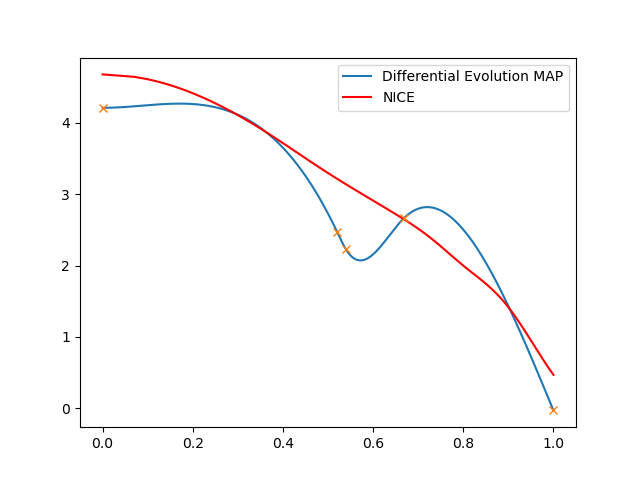

array([-0.03831626, -0.0313102 ,  4.21275751,  2.46613632,  2.6678123 ,
        2.22634255,  0.52072523,  0.66889372,  0.53988728])

In [25]:
post_smooth.ComputeMAP(hyperparameters, verbose=True)

Performing MCMC Sampling of Posterior
MCMC sampling starts
Burn-in


100%|██████████| 500/500 [00:16<00:00, 29.76it/s]


Sampling


100%|██████████| 4000/4000 [02:03<00:00, 32.47it/s]
/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 22.08 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  0%|          | 0/21713 [00:00<?, ?it/s]

Sampling finished. Time Taken: 140.0511965751648 s
Converting the Samples to Profiles


100%|██████████| 21713/21713 [01:53<00:00, 191.40it/s]


Time Taken: 254.18434190750122 s
Computing the mean and 95% confidance intervals


<IPython.core.display.Javascript object>


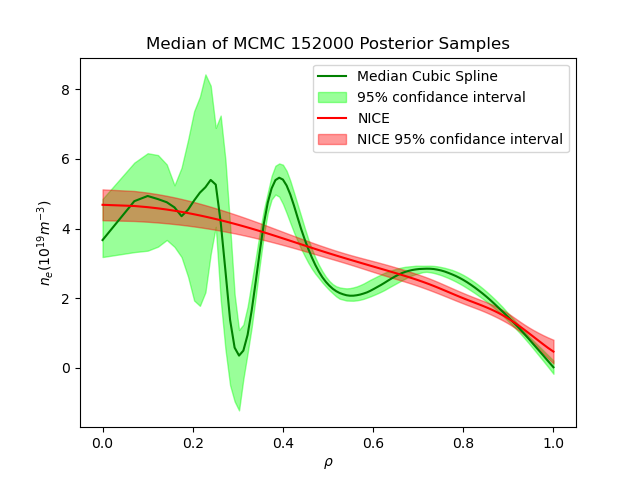

<IPython.core.display.Javascript object>


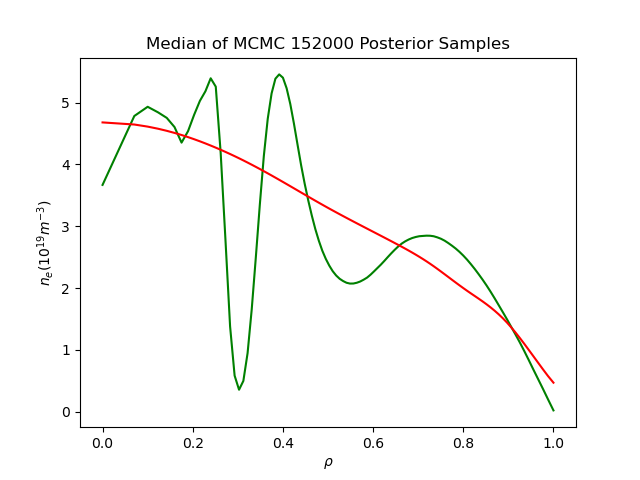

In [12]:
post_smooth.nburn = 500
post_smooth.nsamples = 4000
profile_averages = post_smooth.Plot_posterior(hyperparameters)
a=1                                           

<IPython.core.display.Javascript object>


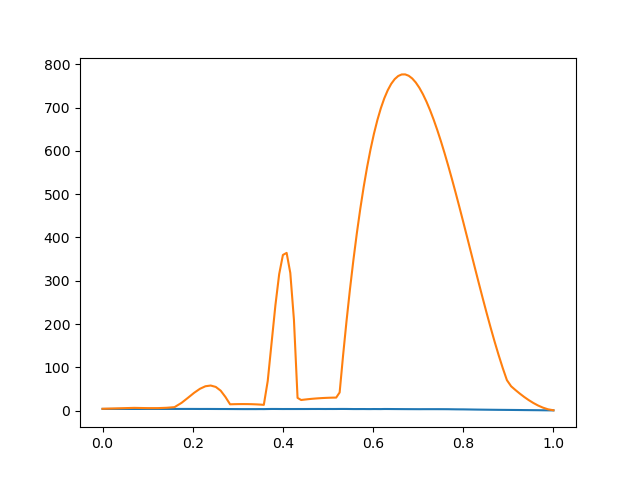

In [61]:
plt.figure()
plt.plot(RHO,profile_averages['median'])
plt.plot(RHO,profile_averages['upper'])
plt.show()

# Trialing Different L Values to find NICE like Profile

To see how close to nice I could get the profile from tuning l I trialed 10 l values from 0.1 to 10.1 and computed the least square error for each with NICE. I then did a finer tuning and took to l with the lowerst least square error and trialed 10 more equally spaced l values within 1 from the previous best. The result was l = 2.2111 has the smallest least square error with NICE, and it looks close too. 


Computing MAP


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Results of MAP for amp: 50 and l: 0.1 


 message: Optimization terminated successfully.
 success: True
     fun: 110.48936083243451
       x: [-1.345e-02  1.499e-02  4.203e+00  2.499e+00  2.781e+00
            2.487e+00  5.111e-01  6.881e-01  5.120e-01]
     nit: 207
    nfev: 28110
Core Gradient Value: -0.013448770770234486
Edeg Spline Value: 0.014988358799900237
Other Spline Values: [4.20343645 2.49910537 2.78128212 2.48660637 0.51108655 0.68813947
 0.51203359]


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


<IPython.core.display.Javascript object>


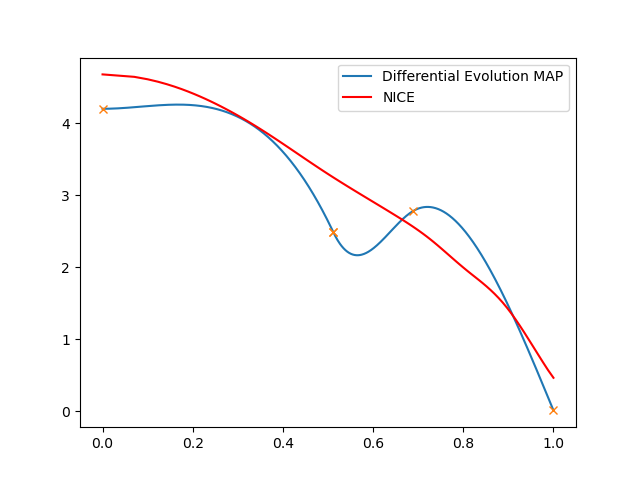

Computing MAP
Results of MAP for amp: 50 and l: 1.1 


 message: Optimization terminated successfully.
 success: True
     fun: 123.80396605105666
       x: [-4.434e-02  2.501e-02  3.072e+00  2.726e+00  3.074e+00
            2.437e+00  7.305e-01  1.671e-04  6.247e-01]
     nit: 458
    nfev: 61995
Core Gradient Value: -0.04434479909683586
Edeg Spline Value: 0.025011101334754038
Other Spline Values: [3.07168470e+00 2.72649531e+00 3.07371312e+00 2.43713351e+00
 7.30531614e-01 1.67122096e-04 6.24662899e-01]


<IPython.core.display.Javascript object>


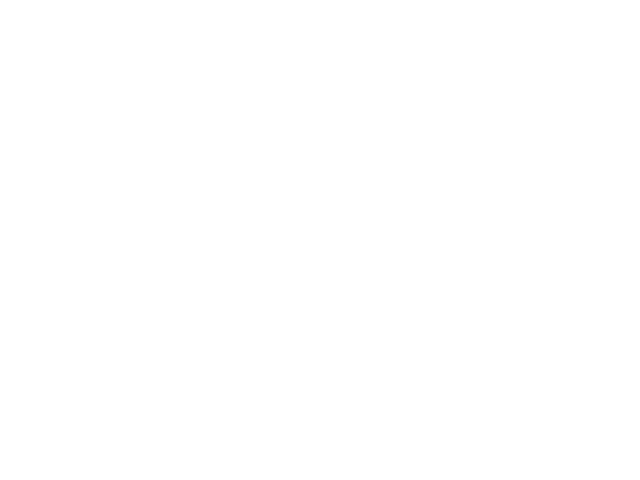

Computing MAP
Results of MAP for amp: 50 and l: 2.1 


 message: Optimization terminated successfully.
 success: True
     fun: 175.42069618259177
       x: [ 1.992e-02  2.312e-01  4.714e+00  2.583e+00  1.070e+00
            2.884e+00  6.874e-01  9.276e-01  5.403e-01]
     nit: 330
    nfev: 44715
Core Gradient Value: 0.019922107668934985
Edeg Spline Value: 0.231209133125991
Other Spline Values: [4.71403416 2.58251495 1.07009727 2.88446955 0.68739204 0.92762522
 0.54029691]


<IPython.core.display.Javascript object>


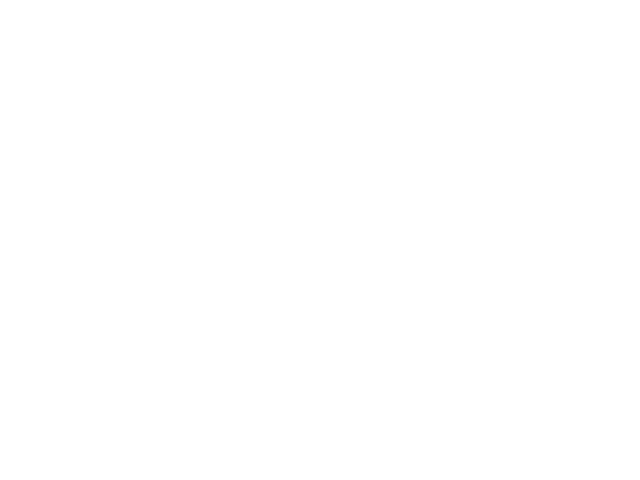

Computing MAP
Results of MAP for amp: 50 and l: 3.1 


 message: Optimization terminated successfully.
 success: True
     fun: 125.25804770046088
       x: [ 1.785e-02  1.345e-03  4.679e+00  3.286e-03  2.802e+00
            2.820e+00  9.999e-01  5.060e-01  5.030e-01]
     nit: 465
    nfev: 62940
Core Gradient Value: 0.017850484128139055
Edeg Spline Value: 0.001344956185771129
Other Spline Values: [4.67931277e+00 3.28616210e-03 2.80249460e+00 2.82023708e+00
 9.99914986e-01 5.05990957e-01 5.03041985e-01]


<IPython.core.display.Javascript object>


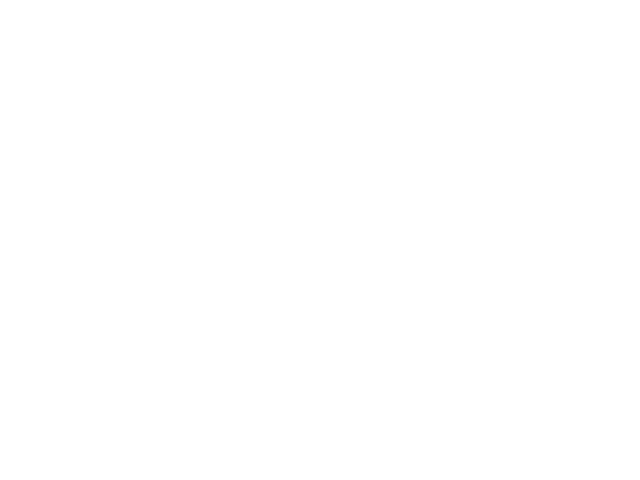

Computing MAP
Results of MAP for amp: 50 and l: 4.1 


 message: Optimization terminated successfully.
 success: True
     fun: 126.06375608631677
       x: [-1.352e-02 -3.354e-04  4.683e+00  3.046e+00  3.331e-03
            2.680e+00  4.636e-01  9.998e-01  5.411e-01]
     nit: 510
    nfev: 69015
Core Gradient Value: -0.013518900484572882
Edeg Spline Value: -0.00033539589143621873
Other Spline Values: [4.68333337e+00 3.04572949e+00 3.33134520e-03 2.68021926e+00
 4.63634043e-01 9.99834044e-01 5.41101026e-01]


<IPython.core.display.Javascript object>


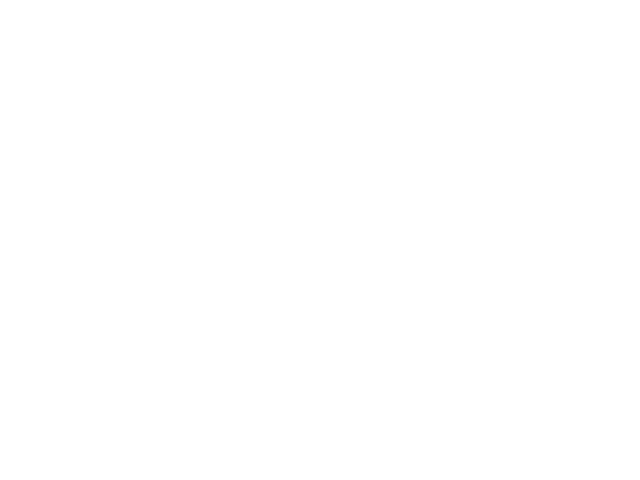

Computing MAP
Results of MAP for amp: 50 and l: 5.1 


 message: Optimization terminated successfully.
 success: True
     fun: 125.7565646583482
       x: [ 9.698e-03 -2.844e-03  4.642e+00  3.114e+00  2.737e+00
            7.614e-04  4.588e-01  5.392e-01  9.998e-01]
     nit: 698
    nfev: 94395
Core Gradient Value: 0.009697673958434017
Edeg Spline Value: -0.0028438958741882625
Other Spline Values: [4.64191569e+00 3.11400351e+00 2.73721655e+00 7.61391060e-04
 4.58768936e-01 5.39166793e-01 9.99828623e-01]


<IPython.core.display.Javascript object>


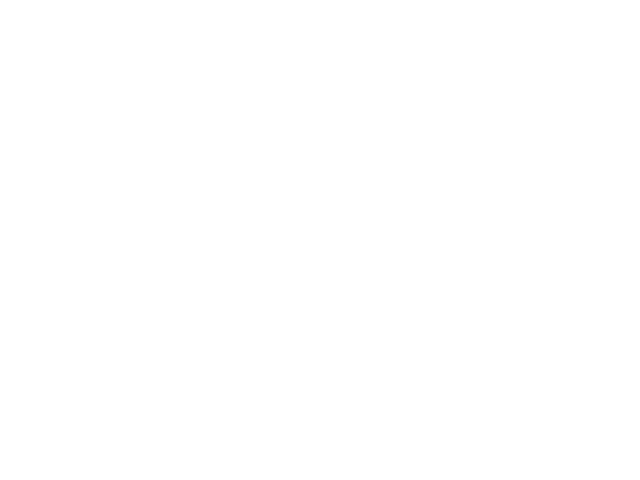

Computing MAP
Results of MAP for amp: 50 and l: 6.1 


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 120.49361020001963
       x: [-3.882e-02  9.676e-03  4.556e+00  3.044e+00  1.866e-02
            3.054e+00  4.544e-01  9.996e-01  4.531e-01]
     nit: 1000
    nfev: 135165
Core Gradient Value: -0.03882159681799835
Edeg Spline Value: 0.009676071974330736
Other Spline Values: [4.55556772 3.04386836 0.01866337 3.05413997 0.45440863 0.99959209
 0.45314336]


<IPython.core.display.Javascript object>


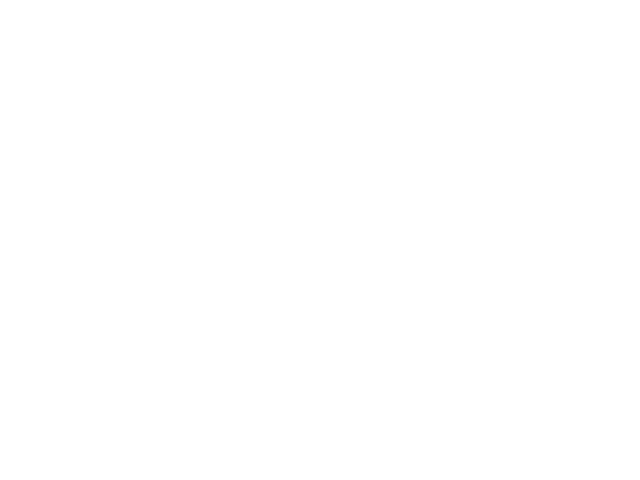

Computing MAP
Results of MAP for amp: 50 and l: 7.1 


 message: Optimization terminated successfully.
 success: True
     fun: 87.99959348777449
       x: [-3.086e-02 -1.993e-02  4.257e+00  1.742e+00  1.809e+00
            1.738e+00  5.957e-01  5.795e-01  5.955e-01]
     nit: 601
    nfev: 81300
Core Gradient Value: -0.030863052707310323
Edeg Spline Value: -0.019933765313623786
Other Spline Values: [4.2573159  1.74231718 1.8090507  1.73791045 0.59573155 0.57954115
 0.59548347]


<IPython.core.display.Javascript object>


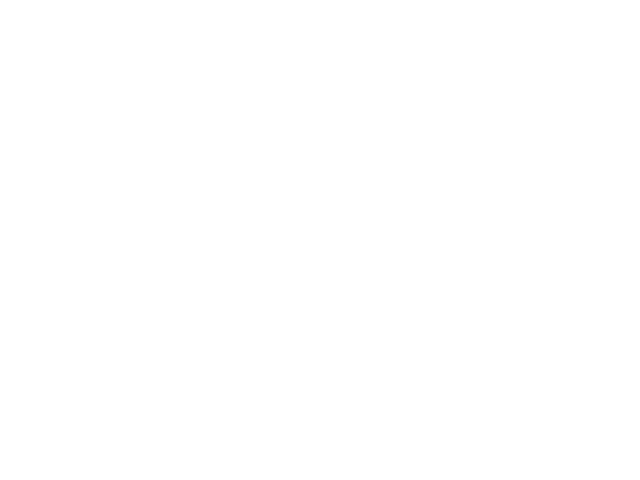

Computing MAP
Results of MAP for amp: 50 and l: 8.1 


 message: Optimization terminated successfully.
 success: True
     fun: 127.75412500376743
       x: [ 4.950e-02  3.125e-03  4.729e+00  2.871e+00  5.086e-03
            2.892e+00  4.888e-01  9.999e-01  4.851e-01]
     nit: 953
    nfev: 128820
Core Gradient Value: 0.0494950750071399
Edeg Spline Value: 0.003125241150979563
Other Spline Values: [4.72904618 2.87105522 0.00508613 2.89225992 0.48879206 0.99990929
 0.48507109]


<IPython.core.display.Javascript object>


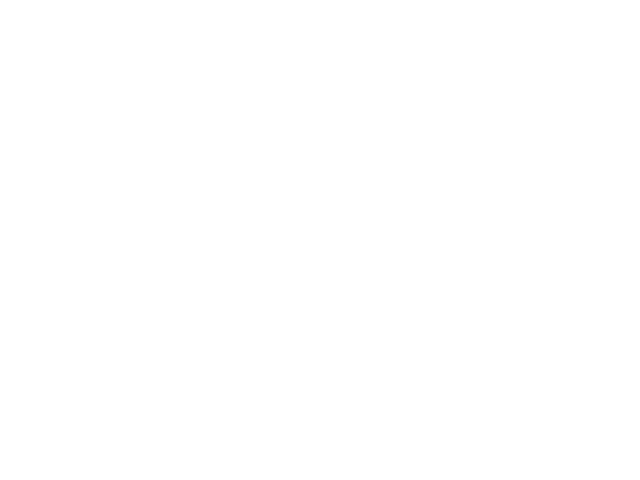

Computing MAP
Results of MAP for amp: 50 and l: 9.1 


 message: Optimization terminated successfully.
 success: True
     fun: 213.24176174615388
       x: [-4.129e-02  4.918e-01  6.010e+00  2.500e+00  5.970e+00
            5.960e+00  7.011e-01  1.108e-02  1.186e-02]
     nit: 542
    nfev: 73335
Core Gradient Value: -0.041291498740757326
Edeg Spline Value: 0.49178383914264157
Other Spline Values: [6.01043608 2.5003661  5.96990298 5.95965082 0.7010793  0.01108042
 0.01186013]


<IPython.core.display.Javascript object>


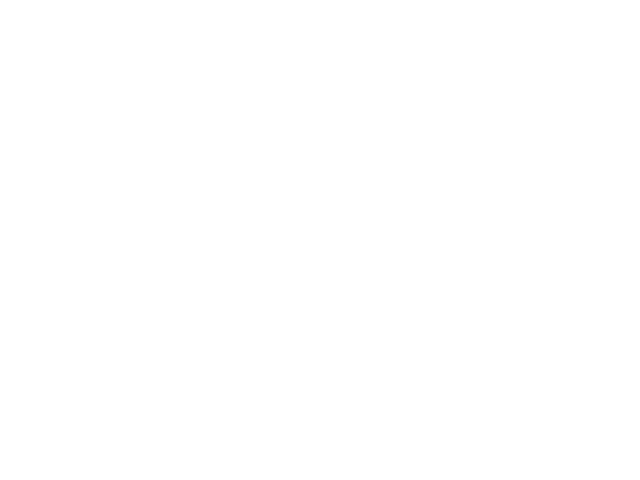

In [8]:
l_trials = np.arange(0.1, 10.1)

lsqe_list = []
profile_list = []
for l in l_trials:
    hyperparameters['L'] = l
    params_map = post_smooth.ComputeMAP(hyperparameters, verbose=True)
    profile = post_smooth.Profile(params_map, nice_rho, hyperparameters)
    lsqe_list.append(np.sum((nice-profile)**2)/len(nice))
    profile_list.append(profile)

In [9]:
#most nice like l
l_nicelike = l_trials[larg]
larg = np.argmin(lsqe_list)
print('NICE like l is', l_nicelike)

NICE like l is 2.1


Computing MAP
Results of MAP for amp: 50 and l: 2.1 


 message: Optimization terminated successfully.
 success: True
     fun: 176.63118276946173
       x: [ 1.024e-02  2.936e-01  4.701e+00  1.335e+00  2.922e+00
            2.321e+00  9.029e-01  5.297e-01  7.562e-01]
     nit: 172
    nfev: 23385
Core Gradient Value: 0.01024023254293327
Edeg Spline Value: 0.29356378329906274
Other Spline Values: [4.70053651 1.33451155 2.92154312 2.32073495 0.90290064 0.52973288
 0.75615687]


<IPython.core.display.Javascript object>


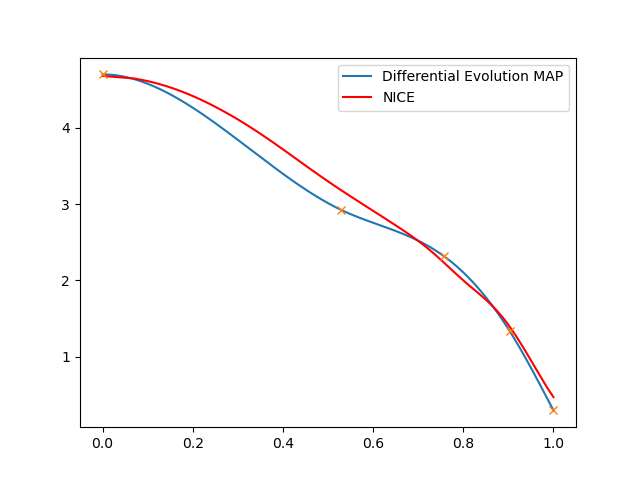

array([0.01024023, 0.29356378, 4.70053651, 1.33451155, 2.92154312,
       2.32073495, 0.90290064, 0.52973288, 0.75615687])

In [10]:
hyperparameters['L'] = l_nicelike
post_smooth.ComputeMAP(hyperparameters, verbose=True)


NICE like l is 2.1
Computing MAP
Results of MAP for amp: 50 and l: 1.1 


 message: Optimization terminated successfully.
 success: True
     fun: 140.4386931062195
       x: [ 5.929e-02  2.694e-02  4.802e+00  1.733e+00  2.556e+00
            2.571e+00  8.821e-01  6.667e-01  6.965e-01]
     nit: 205
    nfev: 27840
Core Gradient Value: 0.059286682151711734
Edeg Spline Value: 0.026939470751511818
Other Spline Values: [4.802017   1.7327099  2.55595411 2.57075998 0.88212234 0.66666308
 0.6965308 ]


<IPython.core.display.Javascript object>


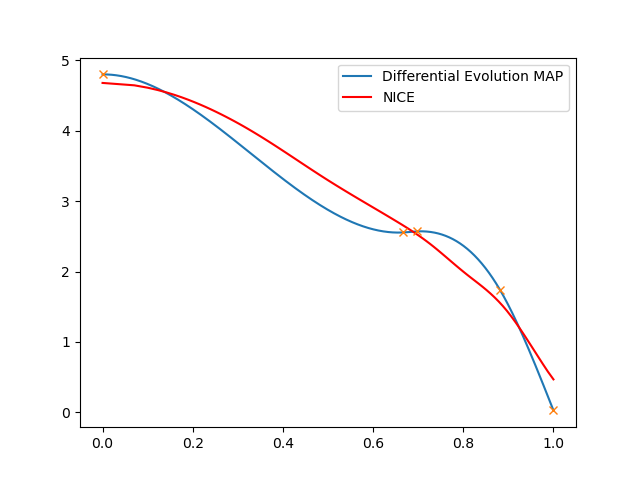

Computing MAP
Results of MAP for amp: 50 and l: 1.3222222222222224 


 message: Optimization terminated successfully.
 success: True
     fun: 143.13694663633424
       x: [-1.896e-02  5.084e-02  4.767e+00  9.536e-02  2.644e+00
            2.492e+00  9.976e-01  6.033e-01  7.433e-01]
     nit: 250
    nfev: 33915
Core Gradient Value: -0.01895923316012038
Edeg Spline Value: 0.05084476595903986
Other Spline Values: [4.7665281  0.09535745 2.64417528 2.49227578 0.9975572  0.60328562
 0.74326313]


<IPython.core.display.Javascript object>


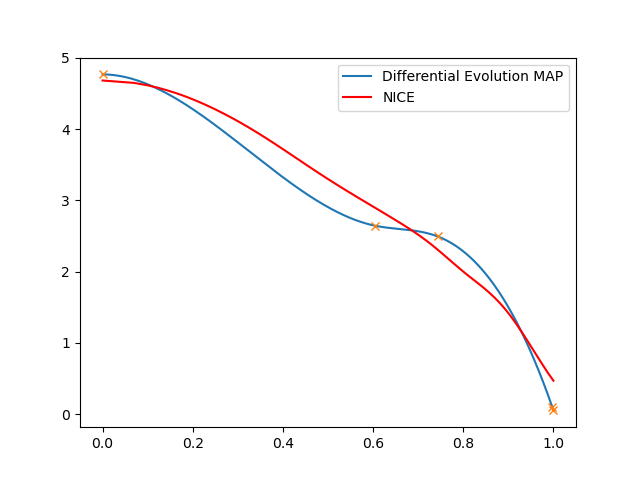

Computing MAP
Results of MAP for amp: 50 and l: 1.5444444444444445 


 message: Optimization terminated successfully.
 success: True
     fun: 148.87042861769868
       x: [ 2.339e-02  4.190e-02  4.799e+00  1.391e+00  2.632e+00
            2.581e+00  9.045e-01  6.192e-01  7.073e-01]
     nit: 315
    nfev: 42690
Core Gradient Value: 0.023388833808698384
Edeg Spline Value: 0.041898643534014623
Other Spline Values: [4.79873639 1.39091585 2.63181101 2.5805257  0.90447926 0.61921421
 0.70725326]


<IPython.core.display.Javascript object>


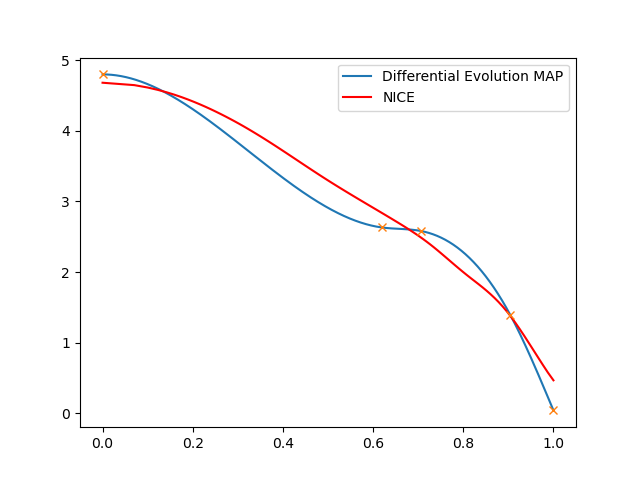

Computing MAP
Results of MAP for amp: 50 and l: 1.7666666666666666 


 message: Optimization terminated successfully.
 success: True
     fun: 95.23605834815449
       x: [-2.219e-02  5.332e-02  4.195e+00  2.141e+00  2.143e+00
            2.610e+00  6.146e-01  6.147e-01  5.140e-01]
     nit: 637
    nfev: 86160
Core Gradient Value: -0.022189468888468566
Edeg Spline Value: 0.05331710625397745
Other Spline Values: [4.19516376 2.14145311 2.14276372 2.60952132 0.61455503 0.61465324
 0.51401055]


<IPython.core.display.Javascript object>


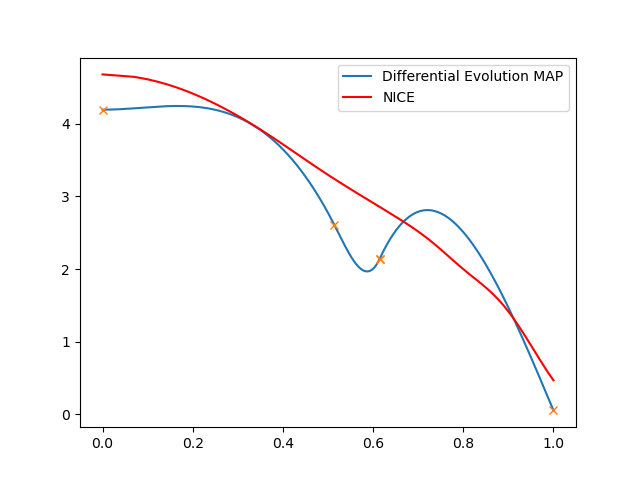

Computing MAP
Results of MAP for amp: 50 and l: 1.988888888888889 


 message: Optimization terminated successfully.
 success: True
     fun: 126.36078896792105
       x: [-2.248e-02  2.503e-04  4.496e+00  3.395e+00  2.733e+00
            2.799e-03  4.064e-01  5.232e-01  9.999e-01]
     nit: 472
    nfev: 63885
Core Gradient Value: -0.022478786195483935
Edeg Spline Value: 0.0002502673313555803
Other Spline Values: [4.49642691e+00 3.39496860e+00 2.73307888e+00 2.79899151e-03
 4.06387064e-01 5.23239442e-01 9.99883178e-01]


<IPython.core.display.Javascript object>


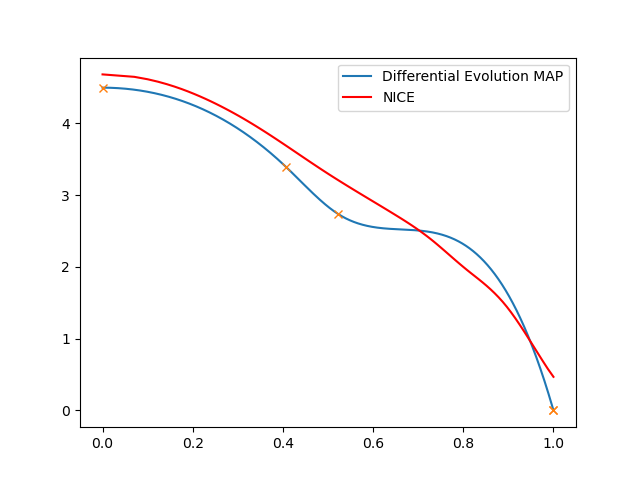

Computing MAP
Results of MAP for amp: 50 and l: 2.2111111111111112 


 message: Optimization terminated successfully.
 success: True
     fun: 182.10624831443994
       x: [ 3.110e-04  2.737e-01  4.681e+00  2.965e+00  1.339e+00
            2.499e+00  5.225e-01  8.991e-01  7.108e-01]
     nit: 198
    nfev: 26895
Core Gradient Value: 0.0003109940831909075
Edeg Spline Value: 0.2737127393519989
Other Spline Values: [4.68074175 2.96501771 1.33942754 2.49928713 0.52247561 0.89913884
 0.71081618]


/tmp/ipykernel_152634/4248933315.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figDifEv = plt.figure()


<IPython.core.display.Javascript object>


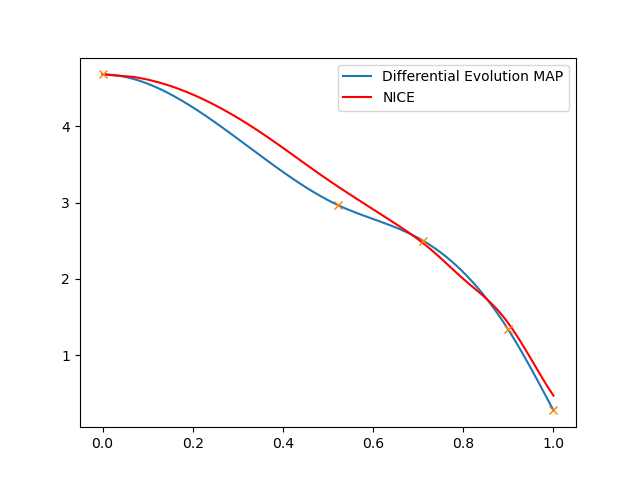

Computing MAP
Results of MAP for amp: 50 and l: 2.4333333333333336 


 message: Optimization terminated successfully.
 success: True
     fun: 93.23505796889714
       x: [ 3.987e-02 -3.854e-03  4.243e+00  2.639e+00  2.157e+00
            2.158e+00  5.121e-01  6.176e-01  6.177e-01]
     nit: 466
    nfev: 63075
Core Gradient Value: 0.039867677672669743
Edeg Spline Value: -0.0038538653452902527
Other Spline Values: [4.24318128 2.63938782 2.15685722 2.1581306  0.5120807  0.61763136
 0.61772704]


<IPython.core.display.Javascript object>


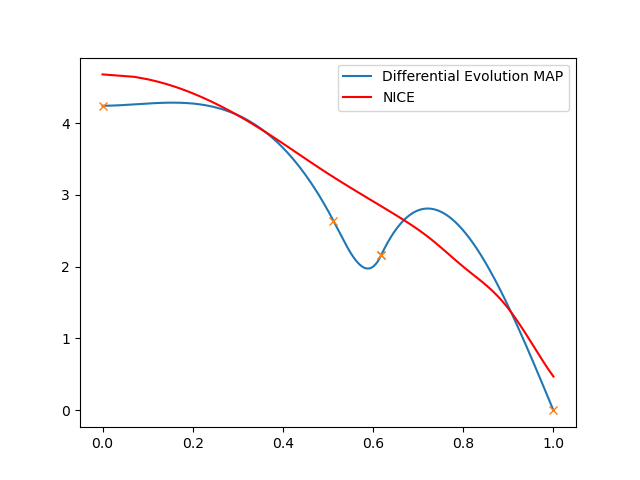

Computing MAP
Results of MAP for amp: 50 and l: 2.6555555555555554 


 message: Optimization terminated successfully.
 success: True
     fun: 93.03605383504244
       x: [-3.327e-02  1.446e-02  4.270e+00  2.182e+00  2.183e+00
            2.594e+00  6.044e-01  6.045e-01  5.128e-01]
     nit: 466
    nfev: 63075
Core Gradient Value: -0.033269569146260614
Edeg Spline Value: 0.014463070622123264
Other Spline Values: [4.26964979 2.18220533 2.18300879 2.59390217 0.60442482 0.60448745
 0.51279976]


<IPython.core.display.Javascript object>


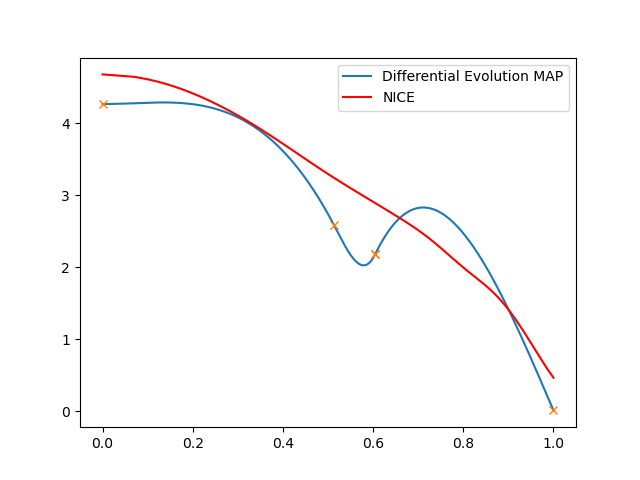

Computing MAP
Results of MAP for amp: 50 and l: 2.8777777777777778 


 message: Optimization terminated successfully.
 success: True
     fun: 91.98224890443485
       x: [-2.691e-02  2.393e-03  4.214e+00  2.070e+00  2.068e+00
            2.487e+00  6.151e-01  6.150e-01  5.235e-01]
     nit: 557
    nfev: 75360
Core Gradient Value: -0.02691431057862076
Edeg Spline Value: 0.0023931738418023762
Other Spline Values: [4.21379938 2.07005285 2.06817484 2.4865385  0.61514547 0.61501852
 0.52353502]


<IPython.core.display.Javascript object>


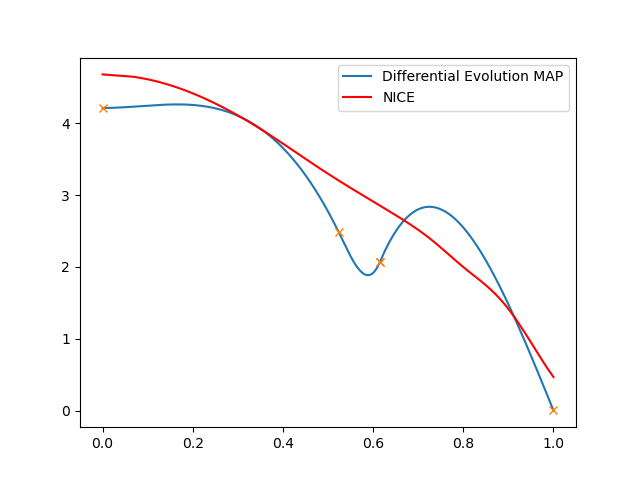

Computing MAP
Results of MAP for amp: 50 and l: 3.1 


 message: Optimization terminated successfully.
 success: True
     fun: 91.96995348889703
       x: [-3.675e-02 -1.076e-02  4.216e+00  2.148e+00  2.647e+00
            2.150e+00  6.170e-01  5.087e-01  6.172e-01]
     nit: 366
    nfev: 49575
Core Gradient Value: -0.036754894260058624
Edeg Spline Value: -0.010758386518259888
Other Spline Values: [4.21555761 2.1481146  2.64696816 2.15017002 0.61701408 0.50874714
 0.61716408]


<IPython.core.display.Javascript object>


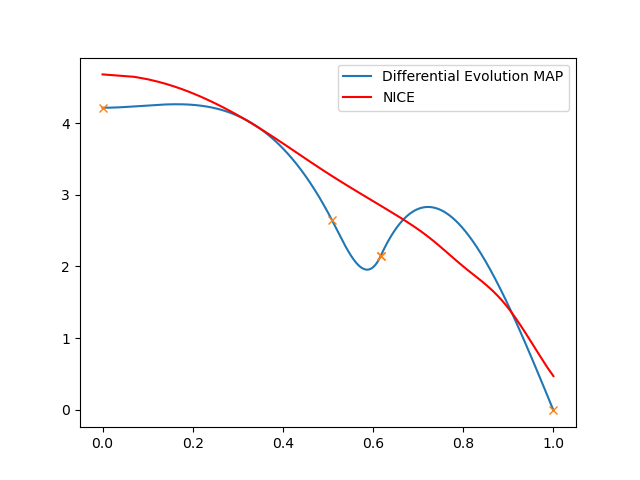

In [11]:
larg = np.argmin(lsqe_list)
l_nicelike = l_trials[larg]
print('NICE like l is', l_nicelike)
l_trials2 = np.linspace(l_nicelike-1, l_nicelike+1,10)

lsqe_list = []
profile_list = []
for l in l_trials2:
    hyperparameters['L'] = l
    params_map = post_smooth.ComputeMAP(hyperparameters, verbose=True)
    profile = post_smooth.Profile(params_map, nice_rho, hyperparameters)
    lsqe_list.append(np.sum((nice-profile)**2)/len(nice))
    profile_list.append(profile)

In [12]:
#most nice like l
larg = np.argmin(lsqe_list)
l_nicelike = l_trials2[larg]
print('NICE like l is', l_nicelike)

NICE like l is 2.2111111111111112


Computing MAP
Results of MAP for amp: 50 and l: 2.2111111111111112 


 message: Optimization terminated successfully.
 success: True
     fun: 181.40885901578406
       x: [-1.590e-02  2.899e-01  4.674e+00  7.177e-01  2.958e+00
            2.576e+00  9.635e-01  5.240e-01  6.905e-01]
     nit: 271
    nfev: 36750
Core Gradient Value: -0.0158959416685987
Edeg Spline Value: 0.2899403170092809
Other Spline Values: [4.674158   0.71769934 2.95752013 2.57556399 0.96352569 0.52401057
 0.69045081]


<IPython.core.display.Javascript object>


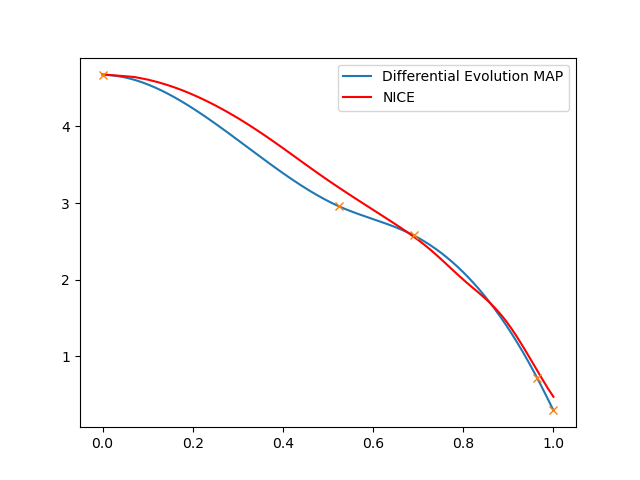

array([-0.01589594,  0.28994032,  4.674158  ,  0.71769934,  2.95752013,
        2.57556399,  0.96352569,  0.52401057,  0.69045081])

In [13]:
hyperparameters['L'] = l_nicelike
post_smooth.ComputeMAP(hyperparameters, verbose=True)


{'NKNOTS': 10, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 2.2111111111111112}
Performing MCMC Sampling of Posterior
MCMC sampling starts
Burn-in


100%|██████████| 500/500 [00:07<00:00, 66.59it/s]


Sampling


100%|██████████| 4000/4000 [00:51<00:00, 77.26it/s]


Sampling finished. Time Taken: 59.32946228981018 s
Converting the Samples to Profiles


100%|██████████| 10284/10284 [00:25<00:00, 407.09it/s]


Time Taken: 85.80952906608582 s
Computing the mean and 95% confidance intervals


<IPython.core.display.Javascript object>


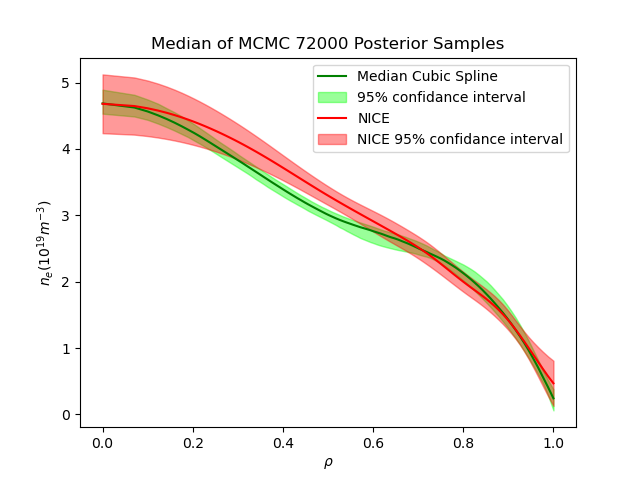

<IPython.core.display.Javascript object>


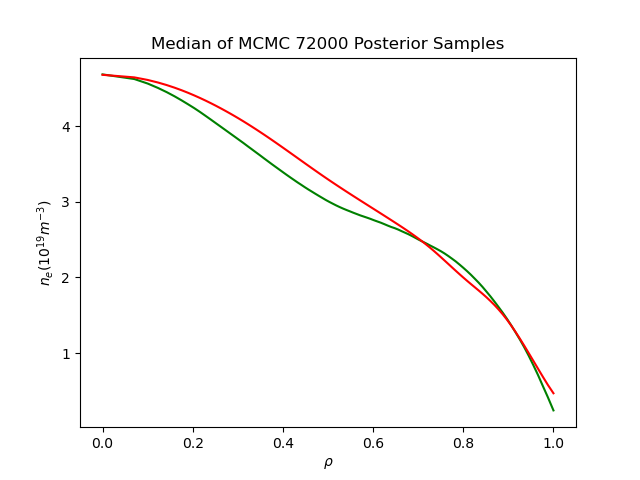

In [14]:
print(hyperparameters)
profile_averages = post_smooth.Plot_posterior(hyperparameters)

<IPython.core.display.Javascript object>


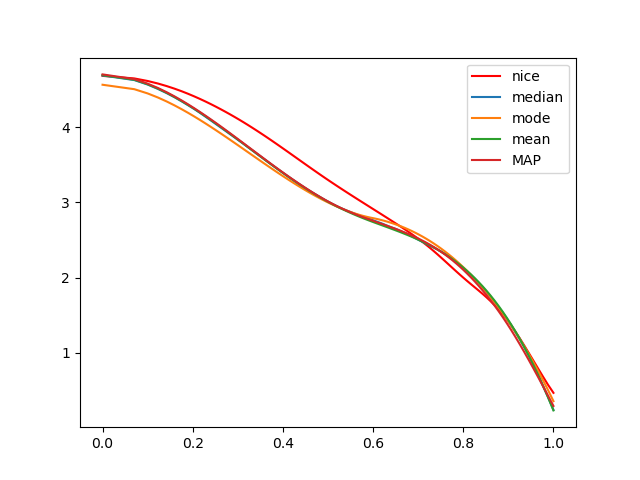

In [19]:
plt.figure()
params_map = np.array([0.01024023, 0.29356378, 4.70053651, 1.33451155, 2.92154312,
               2.32073495, 0.90290064, 0.52973288, 0.75615687])
profile_map = post_smooth.Profile(params_map, RHO, hyperparameters)
plt.plot(nice_rho,nice, 'r', label='nice')
plt.plot(RHO, profile_averages['median'], label='median')
plt.plot(RHO, profile_averages['mode'], label='mode')
plt.plot(RHO, profile_averages['mean'], label='mean')

plt.plot(RHO, profile_map, label='MAP')
plt.legend()
plt.show()

# Equally Spaces Knots

When the knots are close together in $\rho$ and further apart in $n_e$ the cubic spline must have a very large gradient to connect the two. This creates very large dramatic curves that go to extream values. This likely causes the large errors on the MCMC 95% confidance intervals.  
  
To solve this issue the knots will not be equally spaced and not a hyper parameter.

Constants:
Interferometry Data, line integrated density of lasers, $\vec d$  
Edge Knot Location at $\rho=1$  
Core Knot Location at $\rho=0$  

Hyperparameters:
Amplitude, $\sigma$, amp = 50
Lengthscale, $l$ = 4, to be tuned
Number of MCMC Burn Samples, NBURN = 500, lowered to 50, for tuning l
Number of MCMC Sample, NSAMPLES = 4000, lowered to 400, for tuning l
Number of MCMC Walkers = 2*number of cubic spline parameters = 2*19 = 38
Number of Knots, NKNOTS = 5  
Experimental Error, $\sigma_{er}$ = 0.03 (as reported by WEST)   
Standard Deviation of Edge Spline Value, $\sigma_{esv}$ = 0.1   
Standard Deviation of Core Gradient Value, $\sigma_{cgv}$ = 0.1   
Bounds of Knot Locations uniform prior [0,1]  
Bounds of Spline Values uniform prior [0,10]

Cubic Spline Parameters:  
Knot Locations, equally spaced  
Spline Values (except edge), uniform prior  
Edge Spline Value, Gaussian prior  
Core Spline Gradient, Gaussian prior.  

In [7]:
NBURN = 500
NSAMPLES = 4000

# Hyperparamters
NKNOTS = 5
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1
AMP = 50
L = 4
#might not be necessary any more since no uniform dist are used
BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,10) for i in range(NKNOTS-1)]# + [(0,1) for i in range(NKNOTS-2)]
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 
rho_1000 = np.linspace(0,1,1000)
#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
d = interf.lid

hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
hyperbounds = {"NKNOTS":(3,40),"SIGer":(0,0.5),"SIGesv":(0,0.5),"SIGcgv":(0,0.5),'AMP':(0,50),'L':(0,10)}

class PosterioR:
    def __init__(self, hyperbounds, bounds, rho, R, d, nburn, nsamples):
        self.hyperbounds = hyperbounds
        self.bounds = bounds
        self.rho = rho
        self.R = R
        self.d = d
        self.nburn = nburn
        self.nsamples = nsamples
        self.params_map = None
        
        self.profiles_sampled = None

    def Kernel(self, rho1, rho2, hyperparameters):
        amp = hyperparameters['AMP']
        l = hyperparameters['L']
        RHOA, RHOB = np.meshgrid(rho1,rho2)
        return amp**2 * np.exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    
    def Profile(self, params, rho, hyperparameters):
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
#         knot_locations = params[NKNOTS+1:]
        all_knots = np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        #ensure unique to avoid error, x must be increasing
        if len(np.unique(all_knots))<len(all_knots):
            all_knots = all_knots + np.linspace(0,0.000001,len(all_knots))
        sort = np.argsort(all_knots)
        cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
        n_e = cubic_spline(rho)
        return n_e
    def Plot_profile(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        fig_prof = plt.figure()
        plt.plot(self.rho, n_e)
    
    def Log_prior(self, params, hyperparameters):
            #check bounds
        within_bounds = True
        for i in range(len(params)):
            within_bounds = within_bounds and params[i] > self.bounds[i][0] and params[i] < self.bounds[i][1]
        if not within_bounds:
            return -np.inf    
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
#         knot_locations = params[NKNOTS+1:]
        all_knots = np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        K = self.Kernel(all_knots,all_knots, hyperparameters) + np.diag(np.repeat(1e-5,NKNOTS))
        prior_spline_values = mvn(mean=np.zeros(NKNOTS), cov=K)
        return -(esv**2 / hyperparameters['SIGesv']**2) - (cgv**2 /  hyperparameters['SIGcgv']**2) + prior_spline_values.logpdf(x=all_spline_values)

    def Log_likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        LID = R @ n_e
        return np.sum(-(self.d - LID)**2 / hyperparameters['SIGer']**2)
    
    def Log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return -np.inf
        else:
            return log_prior + self.Log_likelihood(params, hyperparameters)

    def Neg_log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return np.inf
        else:
            return -(log_prior + self.Log_likelihood(params, hyperparameters))
    
    def ComputeMAP(self, hyperparameters, verbose=False):
        print('Computing MAP')
        results = differential_evolution(self.Neg_log_posterior, self.bounds, workers=7, args=tuple(hyperparameters.values()), maxiter=5000)
        self.params_map = results.x
        if verbose:
            print('Results of MAP for amp:',hyperparameters['AMP'],'and l:',hyperparameters['L'],'\n\n')
            print(results)
            print('Core Gradient Value:',results.x[0])
            print('Edeg Spline Value:',results.x[1])
            print('Other Spline Values:',results.x[2:])
            
            rho_1000 = np.linspace(0,1,1000)
            params_map=results.x
            cgv, esv = params_map[0:2]
            spline_values = params_map[2:NKNOTS+1]
            #knot_locations = params_map[NKNOTS+1:]
            all_knots = np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
            all_spline_values = np.block([spline_values,esv])
        
            figDifEv = plt.figure()
            plt.plot(rho_1000,self.Profile(results.x, rho_1000, hyperparameters),label='Differential Evolution MAP')
            plt.plot(RHO,nice, 'r', label='NICE')
            plt.plot(all_knots,all_spline_values,'x')
            plt.legend()
            plt.show()
        return self.params_map
    
    def MCMCsampling(self, hyperparameters, recompute_map=False):
        print('Performing MCMC Sampling of Posterior')
        ndim = len(self.bounds)
        nwalkers = ndim * 2
        if recompute_map:
            self.params_map = self.ComputeMAP(hyperparameters)
        params_start = self.params_map + randgen.uniform(0,0.01,(nwalkers, ndim))
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.Log_posterior, kwargs=(hyperparameters))
        print("MCMC sampling starts")
        time1 = time.time()
        print("Burn-in")
        state = sampler.run_mcmc(params_start, self.nburn, progress=True)
        sampler.reset()
        print('Sampling')
        sampler.run_mcmc(state, self.nsamples, progress=True, skip_initial_state_check=False)
        time2 = time.time()
        samples = sampler.get_chain(flat=True)
        print(f'Sampling finished. Time Taken: {time2 - time1} s')
        return samples
    
    def Likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        li = mvn(mean=self.R @ n_e, cov=np.diag(np.repeat(hyperparameters['SIGer'],len(d))))
        return li.pdf(self.d)
    
    def Log_marginal_likelihood(self, samples, hyperparameters):
        #maximizing the marginal likelihood is usefull for paramater optimisation
        #It will be estimates with Harmonic Mean Estimator, 
        #this is the inverse average of the likelihood with posterior samples 
        samples_7split = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Computing Likelihoods:')
        @dask.delayed
        def li_batch_compute(samples):      
            li = self.Likelihood(samples[0], hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                li = np.block([li, self.Likelihood(samples[i,:],hyperparameters)])
            return li
    
        li_batches = []
        for samples_batch in samples_7split:
            li_batches.append(li_batch_compute(samples_batch))

        li_batches = dask.compute(*li_batches)
        log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
        return log_marginal_likelihood
                                          
    def Neglogmargeli(self, hyperparameters):#NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
#             print('Trial Value',hyper_value)
#         hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        samples = self.MCMCsampling(hyperparameters, recompute_map=True)
        return -self.Log_marginal_likelihood(samples, hyperparameters)
      
    def Optimise_hyper(self, hyper, hyperparameters, study_name, verbose=False):
        print('\n\nOptimising the hyperparameter:',hyper)
        
        def objective(trial):
            hyper_value = trial.suggest_float(hyper, self.hyperbounds[hyper][0], self.hyperbounds[hyper][1])
            hyperparameters[hyper] = hyper_value
            return self.Neglogmargeli(hyperparameters)
        storage_name = "sqlite:///{}.db".format(study_name)
        study = optuna.create_study(study_name=study_name, storage=storage_name)
        study.optimize(objective, n_trials=100)
        if verbose:
            print('Results of Optimise for ',hyper,' are:', study.best_params[hyper])
        hyperparameters[hyper] = study.best_params[hyper]
        return hyperparameters
        
    def Plot_posterior(self, hyperparameters):
        time_s = time.time()
        @dask.delayed
        def samples2profiles(samples):
            profiles = self.Profile(samples[0,:], self.rho, hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                profiles = np.block([[profiles],
                                     [self.Profile(samples[i,:], self.rho, hyperparameters)]])
            return profiles
        
        samples = self.MCMCsampling(hyperparameters)
        samples_7 = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Converting the Samples to Profiles')
        profiles_batches = []
        for samples_batch in samples_7:
            profiles_batches.append(samples2profiles(samples_batch))
        profiles_batches = dask.compute(*profiles_batches)
        profiles = profiles_batches[0]
        for i in range(1,len(profiles_batches)):
            profiles = np.block([[profiles],
                                 [profiles_batches[i]]])
        print('Time Taken:', time.time() - time_s,'s')
        
        print('Computing the mean and 95% confidance intervals')
        self.profiles_sampled = profiles
        profiles_mean = profiles.mean(axis=0)
        profiles_median = np.median(profiles, axis=0)
        profiles_mode = stats.mode(profiles, axis=0, keepdims=False).mode.flatten()
        profiles_lower = np.percentile(profiles, 2.5, axis=0)
        profiles_upper = np.percentile(profiles, 97.5, axis=0)
        figMCMC = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.fill_between(self.rho, profiles_lower, profiles_upper,color = (0,1,0,0.4),label='95% confidance interval')
        plt.plot(nice_rho, nice, 'r', label='NICE')
        plt.fill_between(nice_rho, nice_lower, nice_upper, color = (1,0,0,0.4), label='NICE 95% confidance interval')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        figMedain = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.plot(nice_rho,nice, 'r', label='NICE')  
        plt.plot(self.rho, self.Profile(self.params_map, self.rho, hyperparameters),label='MAP')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        return {'mean':profiles_mean,'median':profiles_median,'mode':profiles_mode,'lower':profiles_lower,'upper':profiles_upper}
  
                                     
post_equiknots = PosterioR(hyperbounds, BOUNDS, RHO, R, d, NBURN, NSAMPLES)

Hyper Parameters Are:
{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 4}
Computing MAP


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Results of MAP for amp: 50 and l: 4 


 message: Optimization terminated successfully.
 success: True
     fun: 234.49186235216504
       x: [-4.722e-02  4.950e-01  4.395e+00  4.016e+00  3.275e+00
            2.124e+00]
     nit: 60
    nfev: 5511
Core Gradient Value: -0.047223036448072075
Edeg Spline Value: 0.4949530056544633
Other Spline Values: [4.39532387 4.01617058 3.27481503 2.12449548]


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


<IPython.core.display.Javascript object>


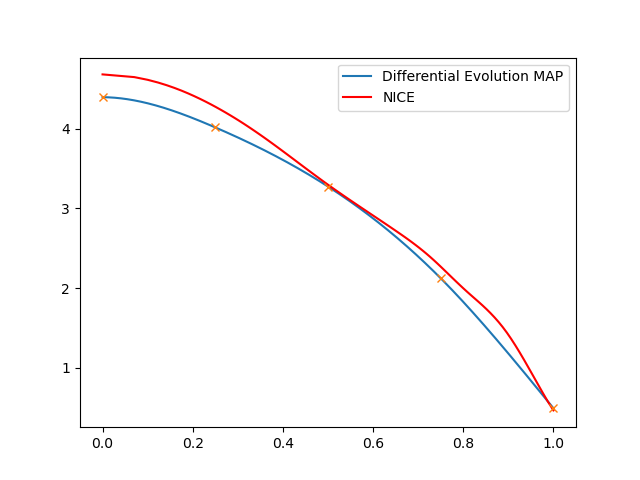

In [8]:
print('Hyper Parameters Are:')
print(hyperparameters)
post_equiknots.ComputeMAP(hyperparameters, verbose=True)
a=1

In [10]:
post_equiknots.nburn = 50
post_equiknots.nsamples = 400
hyperparameters = post_equiknots.Optimise_hyper('L', hyperparameters, study_name='optimise_l_eqidistKnots_5knots_f')
a=1



Optimising the hyperparameter: L


[I 2023-10-26 11:50:28,841] A new study created in RDB with name: optimise_l_eqidistKnots_5knots_f


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


  0%|          | 0/50 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50/50 [00:00<00:00, 116.57it/s]


Sampling


100%|██████████| 400/400 [00:03<00:00, 102.22it/s]


Sampling finished. Time Taken: 4.356029033660889 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1912.56it/s]
[I 2023-10-26 11:50:36,500] Trial 0 finished with value: 8.47707683958009 and parameters: {'L': 9.338023419890085}. Best is trial 0 with value: 8.47707683958009.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.33it/s]


Sampling


 32%|███▏      | 220/684 [00:00<00:00, 2193.14it/s]

Sampling finished. Time Taken: 4.923568248748779 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1815.87it/s]
[I 2023-10-26 11:50:42,925] Trial 1 finished with value: 8.476775804763554 and parameters: {'L': 0.47076223087425983}. Best is trial 1 with value: 8.476775804763554.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 75.34it/s]


Sampling


 29%|██▉       | 199/684 [00:00<00:00, 1989.91it/s]

Sampling finished. Time Taken: 5.260915040969849 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1590.52it/s]
[I 2023-10-26 11:50:49,620] Trial 2 finished with value: 8.476773469939193 and parameters: {'L': 0.2673578251260178}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 183.78it/s]


Sampling


 30%|██▉       | 203/684 [00:00<00:00, 2024.43it/s]

Sampling finished. Time Taken: 4.211413621902466 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1694.12it/s]
[I 2023-10-26 11:50:56,109] Trial 3 finished with value: 8.477058240889484 and parameters: {'L': 8.436159632429796}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.90it/s]


Sampling


 27%|██▋       | 182/684 [00:00<00:00, 1813.21it/s]

Sampling finished. Time Taken: 4.856330871582031 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1670.42it/s]
[I 2023-10-26 11:51:02,299] Trial 4 finished with value: 8.47696083978712 and parameters: {'L': 1.5221335605920305}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 596.85it/s]


Sampling


 26%|██▋       | 181/684 [00:00<00:00, 1802.36it/s]

Sampling finished. Time Taken: 3.6398777961730957 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1688.32it/s]
[I 2023-10-26 11:51:07,983] Trial 5 finished with value: 8.477057385377737 and parameters: {'L': 8.417411067633203}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 84.44it/s]


Sampling


 29%|██▉       | 201/684 [00:00<00:00, 2002.28it/s]

Sampling finished. Time Taken: 5.068058013916016 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1847.97it/s]
[I 2023-10-26 11:51:14,404] Trial 6 finished with value: 8.476822996211856 and parameters: {'L': 1.0737528723721512}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 169.93it/s]


Sampling


 29%|██▊       | 195/684 [00:00<00:00, 1946.30it/s]

Sampling finished. Time Taken: 4.3080549240112305 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1730.10it/s]
[I 2023-10-26 11:51:21,027] Trial 7 finished with value: 8.477057053802785 and parameters: {'L': 7.467879525528836}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 135.57it/s]


Sampling


 30%|███       | 206/684 [00:00<00:00, 2049.74it/s]

Sampling finished. Time Taken: 4.438469886779785 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1968.27it/s]
[I 2023-10-26 11:51:27,936] Trial 8 finished with value: 8.477057272703801 and parameters: {'L': 7.247061663412691}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.05it/s]


Sampling


 15%|█▍        | 101/684 [00:00<00:00, 997.29it/s]]

Sampling finished. Time Taken: 4.9198784828186035 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1632.95it/s]
[I 2023-10-26 11:51:34,261] Trial 9 finished with value: 8.476825429460433 and parameters: {'L': 1.0815306035723948}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 118.42it/s]


Sampling


 25%|██▍       | 170/684 [00:00<00:00, 1696.60it/s]

Sampling finished. Time Taken: 4.462851285934448 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1887.70it/s]
[I 2023-10-26 11:51:40,819] Trial 10 finished with value: 8.477028202202535 and parameters: {'L': 3.4373098301840583}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 92.07it/s]


Sampling


 28%|██▊       | 191/684 [00:00<00:00, 1902.93it/s]

Sampling finished. Time Taken: 4.74737548828125 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1709.87it/s]
[I 2023-10-26 11:51:46,845] Trial 11 finished with value: 8.476775161219653 and parameters: {'L': 0.1210991532931267}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 93.55it/s]


Sampling


 30%|███       | 206/684 [00:00<00:00, 2052.17it/s]

Sampling finished. Time Taken: 4.429196119308472 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1657.45it/s]
[I 2023-10-26 11:51:53,128] Trial 12 finished with value: 8.477006714385166 and parameters: {'L': 2.978859344346867}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 90.86it/s]


Sampling


 32%|███▏      | 221/684 [00:00<00:00, 2204.68it/s]

Sampling finished. Time Taken: 4.790074586868286 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1408.89it/s]
[I 2023-10-26 11:51:59,452] Trial 13 finished with value: 8.476774005291333 and parameters: {'L': 0.24433614860968336}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 104.08it/s]


Sampling


  0%|          | 0/684 [00:00<?, ?it/s]1844.47it/s]

Sampling finished. Time Taken: 4.353765487670898 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1782.23it/s]
[I 2023-10-26 11:52:05,646] Trial 14 finished with value: 8.476987986639475 and parameters: {'L': 2.5937292402577334}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 116.13it/s]


Sampling


 31%|███▏      | 214/684 [00:00<00:00, 2136.72it/s]

Sampling finished. Time Taken: 4.395244598388672 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1617.29it/s]
[I 2023-10-26 11:52:12,094] Trial 15 finished with value: 8.477053289332552 and parameters: {'L': 4.613371647426468}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 85.97it/s]


Sampling


 30%|██▉       | 203/684 [00:00<00:00, 2029.89it/s]

Sampling finished. Time Taken: 5.088098764419556 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1906.07it/s]
[I 2023-10-26 11:52:18,692] Trial 16 finished with value: 8.476773997614234 and parameters: {'L': 0.10925434782213117}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 95.74it/s]


Sampling


 31%|███       | 211/684 [00:00<00:00, 2104.05it/s]

Sampling finished. Time Taken: 4.641811847686768 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1988.34it/s]
[I 2023-10-26 11:52:24,987] Trial 17 finished with value: 8.476979055322147 and parameters: {'L': 2.148165749504045}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 102.99it/s]


Sampling


 18%|█▊        | 126/684 [00:00<00:00, 1251.46it/s]

Sampling finished. Time Taken: 4.5744404792785645 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1647.99it/s]
[I 2023-10-26 11:52:31,063] Trial 18 finished with value: 8.476979896980403 and parameters: {'L': 1.8757921247401994}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 100.96it/s]


Sampling


 25%|██▌       | 174/684 [00:00<00:00, 1738.24it/s]

Sampling finished. Time Taken: 4.387827396392822 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1739.78it/s]
[I 2023-10-26 11:52:37,389] Trial 19 finished with value: 8.477040909758507 and parameters: {'L': 3.8433080942554216}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.40it/s]


Sampling


 30%|██▉       | 202/684 [00:00<00:00, 2015.62it/s]

Sampling finished. Time Taken: 4.9206461906433105 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 2074.70it/s]
[I 2023-10-26 11:52:43,603] Trial 20 finished with value: 8.47677473588738 and parameters: {'L': 0.06069483528095701}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 83.00it/s]


Sampling


 26%|██▌       | 175/684 [00:00<00:00, 1744.87it/s]

Sampling finished. Time Taken: 5.164501428604126 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1904.77it/s]
[I 2023-10-26 11:52:50,237] Trial 21 finished with value: 8.476792645331978 and parameters: {'L': 0.9765579863609649}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 88.75it/s]


Sampling


 31%|███▏      | 215/684 [00:00<00:00, 2144.83it/s]

Sampling finished. Time Taken: 5.085685968399048 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1975.21it/s]
[I 2023-10-26 11:52:56,789] Trial 22 finished with value: 8.476775212655134 and parameters: {'L': 0.010098014812764927}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 94.35it/s]


Sampling


 31%|███▏      | 214/684 [00:00<00:00, 2138.66it/s]

Sampling finished. Time Taken: 4.649775981903076 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1874.65it/s]
[I 2023-10-26 11:53:02,950] Trial 23 finished with value: 8.476981771738709 and parameters: {'L': 1.9263095875422502}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 88.82it/s]


Sampling


 27%|██▋       | 183/684 [00:00<00:00, 1823.94it/s]

Sampling finished. Time Taken: 5.043986082077026 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1779.43it/s]
[I 2023-10-26 11:53:09,323] Trial 24 finished with value: 8.476789757476736 and parameters: {'L': 0.9787926295433339}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 99.22it/s]


Sampling


 28%|██▊       | 190/684 [00:00<00:00, 1896.14it/s]

Sampling finished. Time Taken: 4.68408203125 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 2000.74it/s]
[I 2023-10-26 11:53:15,935] Trial 25 finished with value: 8.476993298784665 and parameters: {'L': 2.5773198576601724}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.66it/s]


Sampling


 31%|███       | 212/684 [00:00<00:00, 2114.32it/s]

Sampling finished. Time Taken: 4.765945196151733 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1725.88it/s]
[I 2023-10-26 11:53:22,076] Trial 26 finished with value: 8.476959334939513 and parameters: {'L': 1.5029547229434563}. Best is trial 2 with value: 8.476773469939193.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.49it/s]


Sampling


 29%|██▉       | 199/684 [00:00<00:00, 1983.21it/s]

Sampling finished. Time Taken: 4.872495889663696 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1717.69it/s]
[I 2023-10-26 11:53:28,307] Trial 27 finished with value: 8.476773119148488 and parameters: {'L': 0.7447775624249919}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 84.82it/s]


Sampling


 25%|██▍       | 169/684 [00:00<00:00, 1684.10it/s]

Sampling finished. Time Taken: 5.1121110916137695 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1750.50it/s]
[I 2023-10-26 11:53:34,889] Trial 28 finished with value: 8.476774211395472 and parameters: {'L': 0.6090840505298936}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 81.05it/s]


Sampling


 25%|██▌       | 173/684 [00:00<00:00, 1722.80it/s]

Sampling finished. Time Taken: 5.066176414489746 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1753.88it/s]
[I 2023-10-26 11:53:41,274] Trial 29 finished with value: 8.47696737105027 and parameters: {'L': 1.5381789348991592}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 95.32it/s]


Sampling


 27%|██▋       | 188/684 [00:00<00:00, 1878.11it/s]

Sampling finished. Time Taken: 4.591650485992432 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1529.57it/s]
[I 2023-10-26 11:53:47,556] Trial 30 finished with value: 8.476990590616047 and parameters: {'L': 2.3960815813793612}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 80.83it/s]


Sampling


 26%|██▋       | 180/684 [00:00<00:00, 1795.44it/s]

Sampling finished. Time Taken: 5.131903409957886 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1860.80it/s]
[I 2023-10-26 11:53:53,967] Trial 31 finished with value: 8.47677519737097 and parameters: {'L': 0.6062855635487672}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 94.59it/s]


Sampling


 27%|██▋       | 188/684 [00:00<00:00, 1878.59it/s]

Sampling finished. Time Taken: 5.049875736236572 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1762.76it/s]
[I 2023-10-26 11:54:00,324] Trial 32 finished with value: 8.476774822020994 and parameters: {'L': 0.5007800497144566}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 88.17it/s]


Sampling


 29%|██▉       | 201/684 [00:00<00:00, 2008.53it/s]

Sampling finished. Time Taken: 4.948819398880005 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1810.44it/s]
[I 2023-10-26 11:54:06,596] Trial 33 finished with value: 8.47677317819204 and parameters: {'L': 0.5884752045178689}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.49it/s]


Sampling


 24%|██▍       | 166/684 [00:00<00:00, 1656.75it/s]

Sampling finished. Time Taken: 5.006651878356934 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1702.37it/s]
[I 2023-10-26 11:54:12,970] Trial 34 finished with value: 8.476922535539462 and parameters: {'L': 1.344393195809289}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 88.64it/s]


Sampling


 29%|██▊       | 196/684 [00:00<00:00, 1955.16it/s]

Sampling finished. Time Taken: 5.021536588668823 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1865.46it/s]
[I 2023-10-26 11:54:19,418] Trial 35 finished with value: 8.476773326687697 and parameters: {'L': 0.717222289457007}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 99.57it/s] 


Sampling


 32%|███▏      | 218/684 [00:00<00:00, 2172.40it/s]

Sampling finished. Time Taken: 4.4840264320373535 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1794.99it/s]
[I 2023-10-26 11:54:25,404] Trial 36 finished with value: 8.476982346718287 and parameters: {'L': 2.00047527712934}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 87.75it/s]


Sampling


 29%|██▊       | 195/684 [00:00<00:00, 1946.01it/s]

Sampling finished. Time Taken: 5.111794471740723 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1822.07it/s]
[I 2023-10-26 11:54:31,818] Trial 37 finished with value: 8.476824842179791 and parameters: {'L': 1.0840420600989709}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 93.68it/s]


Sampling


 30%|██▉       | 205/684 [00:00<00:00, 2041.44it/s]

Sampling finished. Time Taken: 5.028356075286865 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1898.72it/s]
[I 2023-10-26 11:54:38,368] Trial 38 finished with value: 8.476775791244512 and parameters: {'L': 0.8146264883037737}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 97.82it/s] 


Sampling


 28%|██▊       | 193/684 [00:00<00:00, 1928.93it/s]

Sampling finished. Time Taken: 4.80048942565918 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1828.06it/s]
[I 2023-10-26 11:54:44,522] Trial 39 finished with value: 8.476962351575258 and parameters: {'L': 1.5447619182501278}. Best is trial 27 with value: 8.476773119148488.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 82.23it/s]


Sampling


 32%|███▏      | 220/684 [00:00<00:00, 2192.68it/s]

Sampling finished. Time Taken: 5.08910870552063 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1725.00it/s]
[I 2023-10-26 11:54:51,063] Trial 40 finished with value: 8.476772067759715 and parameters: {'L': 0.7210554463411043}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.04it/s]


Sampling


 29%|██▊       | 196/684 [00:00<00:00, 1955.33it/s]

Sampling finished. Time Taken: 5.010370254516602 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1691.30it/s]
[I 2023-10-26 11:54:57,441] Trial 41 finished with value: 8.47677412269221 and parameters: {'L': 0.7841987579962463}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 90.85it/s] 


Sampling


 29%|██▊       | 196/684 [00:00<00:00, 1953.02it/s]

Sampling finished. Time Taken: 5.11515998840332 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1638.91it/s]
[I 2023-10-26 11:55:04,035] Trial 42 finished with value: 8.476773925418028 and parameters: {'L': 0.6109497884115971}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 93.54it/s]


Sampling


 21%|██        | 143/684 [00:00<00:00, 1422.82it/s]

Sampling finished. Time Taken: 4.711378812789917 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1687.01it/s]
[I 2023-10-26 11:55:10,174] Trial 43 finished with value: 8.476952288902277 and parameters: {'L': 1.4448109022600129}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 84.47it/s]


Sampling


 29%|██▉       | 201/684 [00:00<00:00, 2000.72it/s]

Sampling finished. Time Taken: 5.268334150314331 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1784.63it/s]
[I 2023-10-26 11:55:16,846] Trial 44 finished with value: 8.476774982119359 and parameters: {'L': 0.4169659958750021}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 85.88it/s]


Sampling


 27%|██▋       | 188/684 [00:00<00:00, 1875.99it/s]

Sampling finished. Time Taken: 5.055064678192139 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1898.05it/s]
[I 2023-10-26 11:55:23,064] Trial 45 finished with value: 8.476889841217947 and parameters: {'L': 1.2142659609331068}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 140.06it/s]


Sampling


 31%|███       | 209/684 [00:00<00:00, 2088.26it/s]

Sampling finished. Time Taken: 4.180495262145996 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1633.35it/s]
[I 2023-10-26 11:55:29,168] Trial 46 finished with value: 8.476999752717706 and parameters: {'L': 2.8725882894631107}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 87.65it/s]


Sampling


 28%|██▊       | 193/684 [00:00<00:00, 1928.43it/s]

Sampling finished. Time Taken: 4.955655097961426 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1852.78it/s]
[I 2023-10-26 11:55:35,473] Trial 47 finished with value: 8.476981365942866 and parameters: {'L': 1.6940649287855118}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 98.65it/s] 


Sampling


 31%|███       | 212/684 [00:00<00:00, 2111.71it/s]

Sampling finished. Time Taken: 4.814098596572876 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1888.57it/s]
[I 2023-10-26 11:55:41,737] Trial 48 finished with value: 8.476774408837803 and parameters: {'L': 0.4641762400146382}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 99.81it/s] 


Sampling


 32%|███▏      | 216/684 [00:00<00:00, 2153.78it/s]

Sampling finished. Time Taken: 4.638987302780151 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1887.86it/s]
[I 2023-10-26 11:55:47,931] Trial 49 finished with value: 8.47698028480954 and parameters: {'L': 2.3297855100076013}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 88.30it/s]


Sampling


 27%|██▋       | 187/684 [00:00<00:00, 1867.38it/s]

Sampling finished. Time Taken: 4.875066518783569 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1901.01it/s]
[I 2023-10-26 11:55:54,119] Trial 50 finished with value: 8.476820874869192 and parameters: {'L': 1.0575016309738257}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 87.48it/s]


Sampling


 27%|██▋       | 187/684 [00:00<00:00, 1866.25it/s]

Sampling finished. Time Taken: 5.076746940612793 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1914.64it/s]
[I 2023-10-26 11:56:00,676] Trial 51 finished with value: 8.476774648511306 and parameters: {'L': 0.4606158358785243}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 92.02it/s] 


Sampling


 29%|██▉       | 197/684 [00:00<00:00, 1969.15it/s]

Sampling finished. Time Taken: 4.9259819984436035 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1662.53it/s]
[I 2023-10-26 11:56:07,021] Trial 52 finished with value: 8.47677441896766 and parameters: {'L': 0.08483398074363227}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.81it/s]


Sampling


 29%|██▉       | 198/684 [00:00<00:00, 1973.09it/s]

Sampling finished. Time Taken: 5.118619203567505 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1759.13it/s]
[I 2023-10-26 11:56:13,585] Trial 53 finished with value: 8.476773412241414 and parameters: {'L': 0.7833722557989622}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.60it/s]


Sampling


 25%|██▌       | 174/684 [00:00<00:00, 1739.59it/s]

Sampling finished. Time Taken: 4.638067007064819 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1885.06it/s]
[I 2023-10-26 11:56:19,644] Trial 54 finished with value: 8.476984046899142 and parameters: {'L': 1.774797709313014}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 94.78it/s] 


Sampling


 27%|██▋       | 182/684 [00:00<00:00, 1818.63it/s]

Sampling finished. Time Taken: 4.858892202377319 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1696.86it/s]
[I 2023-10-26 11:56:25,902] Trial 55 finished with value: 8.476825615288394 and parameters: {'L': 1.0830440749202368}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 88.43it/s]


Sampling


 30%|██▉       | 205/684 [00:00<00:00, 2047.66it/s]

Sampling finished. Time Taken: 5.081085205078125 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1723.42it/s]
[I 2023-10-26 11:56:32,418] Trial 56 finished with value: 8.476775592569329 and parameters: {'L': 0.0445485797945091}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.25it/s]


Sampling


 31%|███       | 211/684 [00:00<00:00, 2109.83it/s]

Sampling finished. Time Taken: 4.684789180755615 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1631.55it/s]
[I 2023-10-26 11:56:38,637] Trial 57 finished with value: 8.476984691202887 and parameters: {'L': 2.083942489954489}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.29it/s]


Sampling


 23%|██▎       | 155/684 [00:00<00:00, 1546.22it/s]

Sampling finished. Time Taken: 4.92954158782959 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1758.05it/s]
[I 2023-10-26 11:56:44,972] Trial 58 finished with value: 8.476776090228551 and parameters: {'L': 0.8475109173050038}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 90.20it/s]


Sampling


 28%|██▊       | 194/684 [00:00<00:00, 1937.80it/s]

Sampling finished. Time Taken: 4.978525638580322 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1843.29it/s]
[I 2023-10-26 11:56:51,452] Trial 59 finished with value: 8.476774497485568 and parameters: {'L': 0.35690587207419433}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 90.87it/s]


Sampling


 31%|███       | 213/684 [00:00<00:00, 2125.23it/s]

Sampling finished. Time Taken: 4.97633957862854 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1590.66it/s]
[I 2023-10-26 11:56:57,814] Trial 60 finished with value: 8.476856627891706 and parameters: {'L': 1.1545745065841968}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.59it/s]


Sampling


 27%|██▋       | 187/684 [00:00<00:00, 1861.25it/s]

Sampling finished. Time Taken: 5.295639514923096 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1644.98it/s]
[I 2023-10-26 11:57:04,690] Trial 61 finished with value: 8.476773428079895 and parameters: {'L': 0.6384641267685229}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.77it/s]


Sampling


 28%|██▊       | 191/684 [00:00<00:00, 1904.71it/s]

Sampling finished. Time Taken: 4.90220832824707 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1786.42it/s]
[I 2023-10-26 11:57:11,081] Trial 62 finished with value: 8.476776950987519 and parameters: {'L': 0.8255449548149418}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 83.06it/s]


Sampling


 28%|██▊       | 193/684 [00:00<00:00, 1924.08it/s]

Sampling finished. Time Taken: 5.3196892738342285 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1837.49it/s]
[I 2023-10-26 11:57:17,768] Trial 63 finished with value: 8.476936142177825 and parameters: {'L': 1.3526224713145214}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.09it/s]


Sampling


 29%|██▉       | 199/684 [00:00<00:00, 1973.66it/s]

Sampling finished. Time Taken: 5.337581634521484 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1742.68it/s]
[I 2023-10-26 11:57:24,524] Trial 64 finished with value: 8.47677432057496 and parameters: {'L': 0.37247803393046097}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 99.46it/s] 


Sampling


 31%|███       | 209/684 [00:00<00:00, 2086.41it/s]

Sampling finished. Time Taken: 4.605428457260132 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1678.97it/s]
[I 2023-10-26 11:57:30,487] Trial 65 finished with value: 8.476976685548854 and parameters: {'L': 1.7101373751790152}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 89.35it/s]


Sampling


 30%|███       | 207/684 [00:00<00:00, 2061.94it/s]

Sampling finished. Time Taken: 5.311396360397339 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1773.82it/s]
[I 2023-10-26 11:57:37,153] Trial 66 finished with value: 8.47677453307531 and parameters: {'L': 0.03010492738232562}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 82.17it/s]


Sampling


 30%|██▉       | 205/684 [00:00<00:00, 2047.40it/s]

Sampling finished. Time Taken: 5.242538213729858 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 2004.80it/s]
[I 2023-10-26 11:57:43,733] Trial 67 finished with value: 8.47677559346997 and parameters: {'L': 0.8124423915205714}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 93.68it/s]


Sampling


 29%|██▊       | 196/684 [00:00<00:00, 1959.72it/s]

Sampling finished. Time Taken: 4.87153959274292 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1908.35it/s]
[I 2023-10-26 11:57:49,950] Trial 68 finished with value: 8.476932591796887 and parameters: {'L': 1.3682998634727694}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 92.42it/s]


Sampling


 31%|███       | 212/684 [00:00<00:00, 2114.66it/s]

Sampling finished. Time Taken: 5.076979637145996 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1994.19it/s]
[I 2023-10-26 11:57:56,450] Trial 69 finished with value: 8.476775002507136 and parameters: {'L': 0.26992093083063545}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 90.49it/s]


Sampling


 25%|██▍       | 169/684 [00:00<00:00, 1686.99it/s]

Sampling finished. Time Taken: 4.843706130981445 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1885.11it/s]
[I 2023-10-26 11:58:02,705] Trial 70 finished with value: 8.476775348187788 and parameters: {'L': 0.6903600157332014}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 84.59it/s]


Sampling


 30%|██▉       | 202/684 [00:00<00:00, 2016.09it/s]

Sampling finished. Time Taken: 5.193434715270996 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1921.02it/s]

100%|██████████| 684/684 [00:00<00:00, 1673.31it/s]
[I 2023-10-26 11:58:09,312] Trial 71 finished with value: 8.476776572823509 and parameters: {'L': 0.6391865351469832}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 93.12it/s] 


Sampling


 26%|██▋       | 181/684 [00:00<00:00, 1804.37it/s]

Sampling finished. Time Taken: 5.104692697525024 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1828.78it/s]
[I 2023-10-26 11:58:15,668] Trial 72 finished with value: 8.476881164944722 and parameters: {'L': 1.2092477563623252}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.17it/s]


Sampling


 26%|██▋       | 180/684 [00:00<00:00, 1795.50it/s]

Sampling finished. Time Taken: 4.994359254837036 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1995.21it/s]
[I 2023-10-26 11:58:22,179] Trial 73 finished with value: 8.476775014409812 and parameters: {'L': 0.361422617317893}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.17it/s]


Sampling


 30%|██▉       | 202/684 [00:00<00:00, 2017.64it/s]

Sampling finished. Time Taken: 5.190208196640015 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 2055.76it/s]
[I 2023-10-26 11:58:28,746] Trial 74 finished with value: 8.476774952729938 and parameters: {'L': 0.6590679130705961}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 100.32it/s]


Sampling


 32%|███▏      | 218/684 [00:00<00:00, 2170.15it/s]

Sampling finished. Time Taken: 4.671793460845947 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1823.12it/s]
[I 2023-10-26 11:58:35,111] Trial 75 finished with value: 8.476979542059611 and parameters: {'L': 1.8777461111000888}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 93.96it/s]


Sampling


 31%|███       | 211/684 [00:00<00:00, 2108.28it/s]

Sampling finished. Time Taken: 5.246232748031616 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1681.22it/s]
[I 2023-10-26 11:58:41,684] Trial 76 finished with value: 8.476802862316065 and parameters: {'L': 1.0202135899123657}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 84.45it/s]


Sampling


 30%|███       | 207/684 [00:00<00:00, 2067.60it/s]

Sampling finished. Time Taken: 5.135358095169067 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1529.69it/s]
[I 2023-10-26 11:58:48,267] Trial 77 finished with value: 8.476773562753086 and parameters: {'L': 0.26060711607373865}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 87.76it/s]


Sampling


 31%|███▏      | 215/684 [00:00<00:00, 2144.01it/s]

Sampling finished. Time Taken: 5.095690011978149 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1760.94it/s]
[I 2023-10-26 11:58:54,880] Trial 78 finished with value: 8.47677385160842 and parameters: {'L': 0.01417348309511035}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 81.42it/s]


Sampling


 28%|██▊       | 194/684 [00:00<00:00, 1933.59it/s]

Sampling finished. Time Taken: 5.667857646942139 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1768.38it/s]
[I 2023-10-26 11:59:01,976] Trial 79 finished with value: 8.476773142790522 and parameters: {'L': 0.3160201367774584}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.70it/s]


Sampling


 29%|██▉       | 198/684 [00:00<00:00, 1972.98it/s]

Sampling finished. Time Taken: 5.046900987625122 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1782.71it/s]
[I 2023-10-26 11:59:08,402] Trial 80 finished with value: 8.476932712799766 and parameters: {'L': 1.3562354768604739}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 90.33it/s]


Sampling


 18%|█▊        | 120/684 [00:00<00:00, 1192.44it/s]

Sampling finished. Time Taken: 4.970869302749634 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1441.20it/s]
[I 2023-10-26 11:59:14,884] Trial 81 finished with value: 8.476775116811226 and parameters: {'L': 0.30625182370792287}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 85.21it/s]


Sampling


 26%|██▌       | 176/684 [00:00<00:00, 1758.56it/s]

Sampling finished. Time Taken: 5.156409740447998 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1698.05it/s]
[I 2023-10-26 11:59:21,423] Trial 82 finished with value: 8.47678389226663 and parameters: {'L': 0.9267556820844621}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.83it/s]


Sampling


 25%|██▍       | 168/684 [00:00<00:00, 1674.60it/s]

Sampling finished. Time Taken: 4.951871871948242 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1686.85it/s]
[I 2023-10-26 11:59:27,851] Trial 83 finished with value: 8.476774000703424 and parameters: {'L': 0.28137782357665236}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 81.48it/s]


Sampling


 23%|██▎       | 156/684 [00:00<00:00, 1535.20it/s]

Sampling finished. Time Taken: 5.3811445236206055 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1859.38it/s]
[I 2023-10-26 11:59:34,651] Trial 84 finished with value: 8.476775608764234 and parameters: {'L': 0.6504975643893359}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 92.64it/s]


Sampling


 27%|██▋       | 183/684 [00:00<00:00, 1828.35it/s]

Sampling finished. Time Taken: 4.904608249664307 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1884.75it/s]
[I 2023-10-26 11:59:40,981] Trial 85 finished with value: 8.476785198540178 and parameters: {'L': 0.9402969407579012}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.01it/s]


Sampling


 31%|███▏      | 215/684 [00:00<00:00, 2147.20it/s]

Sampling finished. Time Taken: 4.95792293548584 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1818.84it/s]
[I 2023-10-26 11:59:47,324] Trial 86 finished with value: 8.47697318932462 and parameters: {'L': 1.621438453079187}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 97.28it/s]


Sampling


 30%|███       | 207/684 [00:00<00:00, 2066.12it/s]

Sampling finished. Time Taken: 4.639971733093262 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1813.75it/s]
[I 2023-10-26 11:59:53,360] Trial 87 finished with value: 8.47677422036685 and parameters: {'L': 0.23487711587390803}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 92.33it/s]


Sampling


 31%|███       | 213/684 [00:00<00:00, 2127.29it/s]

Sampling finished. Time Taken: 5.13760232925415 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1734.97it/s]
[I 2023-10-26 11:59:59,946] Trial 88 finished with value: 8.476773867415979 and parameters: {'L': 0.46959542838961144}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 83.27it/s]


Sampling


 31%|███▏      | 215/684 [00:00<00:00, 2142.08it/s]

Sampling finished. Time Taken: 5.072431802749634 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1885.61it/s]
[I 2023-10-26 12:00:06,421] Trial 89 finished with value: 8.476874003254586 and parameters: {'L': 1.1704413495139963}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.17it/s]


Sampling


 29%|██▉       | 198/684 [00:00<00:00, 1978.23it/s]

Sampling finished. Time Taken: 5.00395393371582 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1831.12it/s]
[I 2023-10-26 12:00:12,895] Trial 90 finished with value: 8.476774791174265 and parameters: {'L': 0.5594654418100135}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 87.72it/s]


Sampling


 28%|██▊       | 191/684 [00:00<00:00, 1903.82it/s]

Sampling finished. Time Taken: 4.945162773132324 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1761.56it/s]
[I 2023-10-26 12:00:19,323] Trial 91 finished with value: 8.476774357715229 and parameters: {'L': 0.07912112597401871}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 84.21it/s]


Sampling


 31%|███       | 210/684 [00:00<00:00, 2094.29it/s]

Sampling finished. Time Taken: 5.295285940170288 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1638.14it/s]
[I 2023-10-26 12:00:26,203] Trial 92 finished with value: 8.476774622711433 and parameters: {'L': 0.22511972589243479}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.45it/s]


Sampling


 30%|███       | 208/684 [00:00<00:00, 2072.14it/s]

Sampling finished. Time Taken: 5.0902016162872314 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1664.30it/s]
[I 2023-10-26 12:00:32,762] Trial 93 finished with value: 8.476773210537813 and parameters: {'L': 0.03226713156103045}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 92.47it/s]


Sampling


 31%|███       | 213/684 [00:00<00:00, 2126.67it/s]

Sampling finished. Time Taken: 4.829142332077026 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1348.42it/s]
[I 2023-10-26 12:00:39,198] Trial 94 finished with value: 8.476774755884254 and parameters: {'L': 0.784604201645859}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.03it/s]


Sampling


 30%|██▉       | 202/684 [00:00<00:00, 2014.49it/s]

Sampling finished. Time Taken: 5.450099945068359 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1531.38it/s]
[I 2023-10-26 12:00:46,104] Trial 95 finished with value: 8.476773147062488 and parameters: {'L': 0.561873479418857}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.52it/s]


Sampling


 29%|██▊       | 195/684 [00:00<00:00, 1947.20it/s]

Sampling finished. Time Taken: 5.053531169891357 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1683.17it/s]
[I 2023-10-26 12:00:52,422] Trial 96 finished with value: 8.47679262166188 and parameters: {'L': 0.9754167878827469}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 92.33it/s]


Sampling


 24%|██▎       | 162/684 [00:00<00:00, 1618.11it/s]

Sampling finished. Time Taken: 5.017590522766113 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 2004.98it/s]
[I 2023-10-26 12:00:58,840] Trial 97 finished with value: 8.47677362799028 and parameters: {'L': 0.6207082298225515}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 86.81it/s]


Sampling


 23%|██▎       | 157/684 [00:00<00:00, 1568.99it/s]

Sampling finished. Time Taken: 5.014787673950195 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1811.11it/s]
[I 2023-10-26 12:01:05,190] Trial 98 finished with value: 8.476953871753597 and parameters: {'L': 1.4479173143867528}. Best is trial 40 with value: 8.476772067759715.


Performing MCMC Sampling of Posterior
Computing MAP
MCMC sampling starts
Burn-in


100%|██████████| 50/50 [00:00<00:00, 91.49it/s]


Sampling


 26%|██▌       | 177/684 [00:00<00:00, 1768.77it/s]

Sampling finished. Time Taken: 4.8559393882751465 s
Computing Likelihoods:


100%|██████████| 684/684 [00:00<00:00, 1785.07it/s]
[I 2023-10-26 12:01:11,356] Trial 99 finished with value: 8.476876401448285 and parameters: {'L': 1.222333552029832}. Best is trial 40 with value: 8.476772067759715.


Computing MAP
Results of MAP for amp: 50 and l: 0.7210554463411043 


 message: Optimization terminated successfully.
 success: True
     fun: 138.50758091184798
       x: [-4.310e-02  9.754e-02  4.039e+00  4.420e+00  2.646e+00
            2.655e+00]
     nit: 38
    nfev: 3531
Core Gradient Value: -0.0431047155920018
Edeg Spline Value: 0.09753759602279644
Other Spline Values: [4.03873149 4.42040489 2.64647457 2.65452043]


<IPython.core.display.Javascript object>


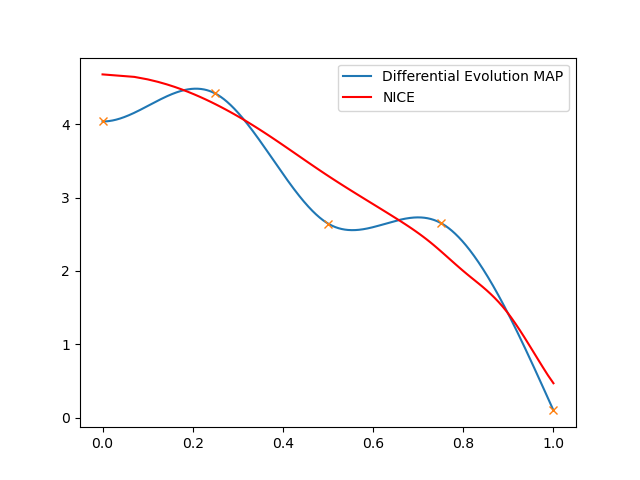

In [11]:
post_equiknots.ComputeMAP(hyperparameters, verbose=True)
a=1

{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 0.7210554463411043}
Performing MCMC Sampling of Posterior
MCMC sampling starts
Burn-in


100%|██████████| 500/500 [00:05<00:00, 93.72it/s]


Sampling


100%|██████████| 4000/4000 [00:44<00:00, 89.48it/s]
/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 39.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Sampling finished. Time Taken: 50.064892530441284 s
Converting the Samples to Profiles


100%|██████████| 6856/6856 [00:13<00:00, 518.00it/s]


Time Taken: 63.86581039428711 s
Computing the mean and 95% confidance intervals


<IPython.core.display.Javascript object>


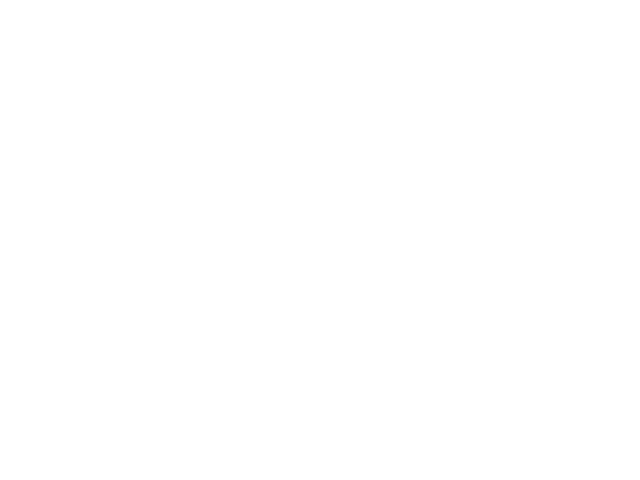

<IPython.core.display.Javascript object>


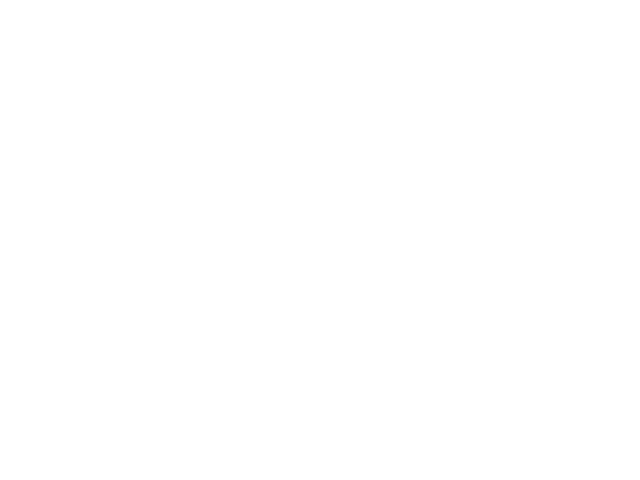

In [15]:
hyperparameters['L'] = 0.7210554463411043
post_equiknots.nburn = 500
post_equiknots.nsamples = 4000
print(hyperparameters)
profile_averages = post_equiknots.Plot_posterior(hyperparameters)
a=1                                           

<IPython.core.display.Javascript object>


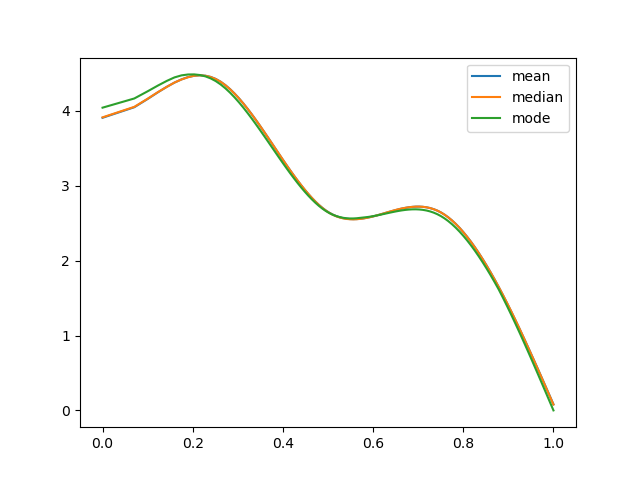

In [14]:
fig = plt.figure()
plt.plot(RHO,profile_averages['mean'],label='mean')
plt.plot(RHO,profile_averages['median'],label='median')
plt.plot(RHO,profile_averages['mode'],label='mode')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


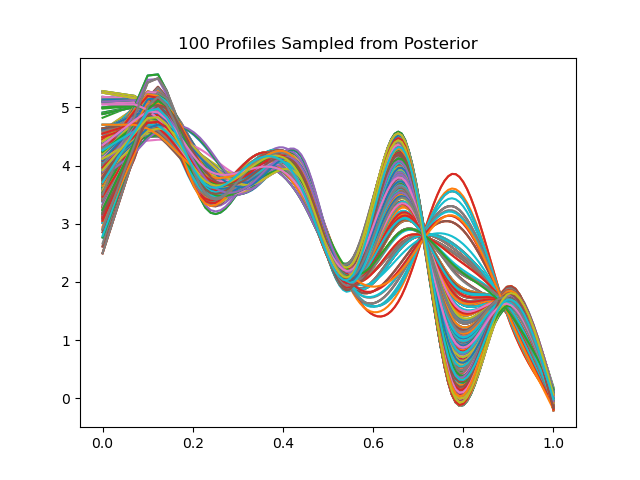

In [20]:
# Other Interesting Graphs

# Plotting 100 MCMC samples

fig100prof = plt.figure()
plt.title('100 Profiles Sampled from Posterior')
for prof in post.profiles_sampled[-1000:]:
    plt.plot(RHO, prof)
plt.show()


In [ ]:
# RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 

# #geo is line geometry, equi are the fulxsurfaces equilibrium
# R = compute_response_matrix(geo, equi, RHO)
# SPLINE_VAL_UPPER = 10
# d = interf.lid

# # Hyperparamters
# NKNOTS = 6
# SIGer = 0.03
# SIGesv = 0.1
# SIGcgv = 0.1

# BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,1) for i in range(NKNOTS-2)]+[(0,10) for i in range(NKNOTS-1)]

# def Gen_init_params():
#     initial_cgv = randgen.normal(0,SIGcgv)
#     initial_esv = randgen.normal(0,SIGesv)
#     initial_knot_locations = randgen.uniform(0,1,NKNOTS-2)
#     initial_spline_values = randgen.uniform(0,SPLINE_VAL_UPPER,NKNOTS-1)

#     #Core Gradient Value, Edge Spline Value, Knot Locations, Spline Values
#     initial_params = np.array([initial_cgv,initial_esv]+list(initial_knot_locations)+list(initial_spline_values))
#     return initial_params

# initial_params = Gen_init_params()
    
# def Profile(params):
#     cgv, esv = params[0:2]
#     knot_locations, spline_values = params[2:2+NKNOTS-2], params[2+NKNOTS-2:]
#     all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
#     all_spline_values = np.block([spline_values,esv])
    
#     #ensure unique to avoid error, x must be increasing
#     if len(np.unique(all_knots))<len(all_knots):
#         all_knots = all_knots + np.linspace(0,0.00001,len(all_knots))
#     sort = np.argsort(all_knots)
# #     print(len(knots))
# #     print(sort)
# #     print(len(np.block([spline_values[sort],esv])))
# #     print(cgv)
#     cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
#     n_e = cubic_spline(RHO)
#     return n_e

# def Log_prior(params):
#     cgv, esv = params[0:2]
#     #check bounds
#     within_bounds = True
#     for i in range(len(params)):
#         within_bounds = within_bounds and params[i] > BOUNDS[i][0] and params[i] < BOUNDS[i][1]
#     if not within_bounds:
#         return -np.inf    
#     return -(esv**2 / SIGesv**2) - (cgv**2 / SIGcgv**2)

# def Log_likelihood(params):
#     n_e = Profile(params)
#     LID = R @ n_e
#     return np.sum(-(d - LID)**2 / SIGer**2)

# def Log_posterior(params):
#     log_prior = Log_prior(params)
#     #
#     if not np.isfinite(log_prior):
#             return +np.inf
#     else:
#             return -log_prior + Log_likelihood(params)

# neg_log_post = lambda x: -Log_posterior(x)
# # map with differential evolution
# results = differential_evolution(Log_posterior, BOUNDS, workers=7)
# # results = minimize(neg_log_post,initial_params)
# # print(results)

In [ ]:
# params_map=results.x
# cgv, esv = params_map[0:2]
# knot_locations, spline_values = params_map[2:2+NKNOTS-2], params_map[2+NKNOTS-2:]
# all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
# all_spline_values = np.block([spline_values,esv])

# figDifEv = plt.figure()
# plt.plot(RHO,Profile(results.x),label='Differential Evolution MAP')
# plt.plot(RHO,nice, 'r', label='NICE')
# plt.plot(all_knots,all_spline_values,'.')
# plt.legend()

In [ ]:
# import emcee
# import time
# from scipy import stats
# from tqdm import tqdm

# NBURN = 2000
# NSAMPLES = 2000

# # def samples2profiles(samples):
# #     profiles = Profile(samples[0,:])
# #     prog_bar = tqdm(range(1,samples.shape[0])) 
# #     for i in prog_bar:
# #         profiles = np.block([[profiles],
# #                              [Profile(samples[i,:])]])
# #     return profiles
# # # mcmc
# # Sampling

# ndim = len(initial_params)
# nwalkers = ndim * 6

# params_start = initial_params
# # params_start = params_map + 0.01 * np.random.randn(nwalkers, ndim)
# for i in range(nwalkers-1):
#     init_params = Gen_init_params()
#     params_start = np.block([[params_start],
#                              [init_params]])

# print(np.linalg.cond(params_start))
    
